# Visualising a Convolutional Neural Network

In [1]:
# general data and misc libraries
import pandas as pd
import numpy as np
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# set default colour map to use
plt.rcParams['image.cmap'] = 'Greys'

# tensorflow/keras for cnn training
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

# sklearn component analysis and utilities
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [2]:
class NetworkVisualiser:
    def __init__(self, layers, data_file='train.csv',label_col='label',
                 num_classes=10,img_rows=28,img_cols=28):
        
        # definition of network infrastructure
        self.layers = layers
        # no. layers in defined network
        self.n_layers = len(layers)

        # no. of classes to identify in images
        self.num_classes = num_classes
        # height of images in pixels 
        self.img_rows = img_rows
        # width of images in pixels
        self.img_cols = img_cols
        
        # load data file
        self.load_data(data_file, label_col)
                
    def load_data(self, data_file, label_col):
        print('Loading data...')
        df = pd.read_csv(data_file)
        print('Shape of data file:',df.shape)

        # get data excluding label column
        X = df.drop(label_col,axis=1)
       
        # reconstruct images from flattened rows
        X = X.values.reshape(len(X),self.img_rows,self.img_cols,1)
        
        # normalise X to lie between 0 and 1
        X = X/X.max()
       
        self.X = X
        print('Shape of network input:',X.shape)

        # extract true label of each image
        self.labels = df[label_col].values
        
        # convert labels in to dummy vectors
        y = keras.utils.to_categorical(self.labels, self.num_classes)
        self.y = y
        print('Shape of label vectors:',y.shape)
        print('First label vector:',y[0])
        
    def show_images(self, images_per_class=10):
        plt.figure(figsize=(images_per_class,self.num_classes))

        for i in range(self.num_classes):
            # select images in class i
            tmp = self.X[self.y[:,i]==1]

            # display 1st 10 images in class i
            for j in range(10):
                plt.subplot(self.num_classes,10,(10*i)+(j+1))
                plt.imshow(tmp[j][:,:,0])

                # use the same colour range for each image
                plt.clim(0,1)
                # don't show axes
                plt.axis('off')
                
    def fit(self,
            loss=keras.losses.categorical_crossentropy,
            optimizer='adam', metrics=['accuracy'],
            epochs=3, batch_size=100, validation_split=0.2):
        
        # Buld model
        self.model = Sequential()

        # add each defined layer to the model
        for layer in layers:
            self.model.add(layer)
            
        # get layer names
        self.layer_names = [self.model.layers[i].name for i in range(self.n_layers)]

        # set model optimisation parameters
        self.model.compile(loss=loss,optimizer=optimizer,
                           metrics=metrics)

        # Fit model
        self.model.fit(self.X, self.y,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split = validation_split)
        
        # calculate output at each network layer
        self.set_layer_outputs()

    def set_layer_outputs(self):        
        # Calculate representation of the image in each layer
        # of the network.
        print('Calculating output at each layer...')
        # maximum no. filters in any convolutional layer, used to define figure sizes later
        # initialise at 9 (min fig size), overwrite in loop if a layer has more than 9
        self.max_filters = 9

        self.layer_out = []
        prev_layer_out = None

        for key in self.layer_names:
            # create a model consisting of only the current layer
            layer_model = Sequential()
            layer_model.add(self.model.get_layer(key))

            # if this is the first layer, predict using the input images
            if prev_layer_out is None:
                curr_layer_out = layer_model.predict(self.X)
                #self.layer_out.append(layer_model.predict(self.X))
            # otherwise, predict using output of previous layer
            else:
                curr_layer_out = layer_model.predict(prev_layer_out)

            self.layer_out.append(curr_layer_out)
            
            # check if this is a convolution layer with more filters
            # than the current maximum.
            if curr_layer_out.ndim==4:
                n_filters = curr_layer_out.shape[-1]
                if n_filters>self.max_filters:
                    self.max_filters = n_filters

            prev_layer_out = curr_layer_out

            print(key, 'layer has shape',curr_layer_out.shape)
            
        # probability network assigns to correct label for each image
        # (self.layer_out[-1] is output layer)
        self.true_prob = pd.Series([self.layer_out[-1][i,self.labels[i]] for i in range(len(self.labels))])

        
    def show_conf_matrix(self):
        # calculate confusion matrix
        cm=confusion_matrix(self.labels,
                            self.layer_out[-1].argmax(axis=1))

        # convert to percentages
        cm=100*cm/cm.sum(axis=1)

        # display
        plt.figure(figsize=(10,8))
        sns.heatmap(cm,annot=True,square=True,cmap='Reds',fmt='.1f',
                    vmax=2*max([np.triu(cm,k=1).max(),np.tril(cm,k=-1).max()]))
        # vmax: used to limit range of colour bar to highlight incorrect predictions,
        # rather than letting diagonal dominate. Current limit is double the maximum
        # incorrect prediction prediction for any number (2*max in upper or lower triangle).
        plt.ylabel('TRUE')
        plt.xlabel('PREDICTED')
        
    def tsne_layers(self,img_ids):
        # t-sne to see distinction between digits at different layers
        print('Calculating TSNE representations...')
        # TSNE too computationally expensive to run on data with many features.
        # First use PCA to extract the first num_classes components, then follow with TSNE.
        pipe = Pipeline([('pca',PCA(n_components=self.num_classes)),('tsne',TSNE())])

        # make figure
        rows = ceil(np.sqrt(self.n_layers+1))
        cols = ceil((self.n_layers+1)/rows)
        plt.figure(figsize=(5*cols,4*rows))

        # visualise structure of input 
        i=1
        print('Input...',end='')
        # flatten data
        pipe_in = self.X[img_ids].reshape([len(img_ids),-1])
        # transform data
        pipe_out = pipe.fit_transform(pipe_in)
        # plot data, with points coloured by class
        plt.subplot(rows,cols,i)
        plt.scatter(pipe_out[:,0],pipe_out[:,1],c=self.labels[img_ids],cmap='tab10',s=2)
        plt.xticks([]), plt.yticks([])
        plt.colorbar()
        plt.title('Input')
        i+=1

        # visualise structure of network layers
        for id_layer in range(self.n_layers):
            key = self.layer_names[id_layer]
            out = self.layer_out[id_layer]
            print(key+'...',end='')
            
            pipe_in = out[img_ids].reshape([len(img_ids),-1])
            pipe_out = pipe.fit_transform(pipe_in)

            plt.subplot(rows,cols,i)
            plt.scatter(pipe_out[:,0],pipe_out[:,1],c=self.labels[img_ids],cmap='tab10',s=2)
            plt.xticks([]), plt.yticks([])
            plt.colorbar()
            plt.title(key)
            i+=1
        print('Done!')
        
    # visualise representation of an image in each layer
    # of the network.
    def visualise_network(self,img_id):
        # no. rows in figure (including extra row for input layer)
        nrows = self.n_layers+1
        # no. additional columns for text labels
        txtwidth = max([int(self.max_filters/12),2])
        ncols = self.max_filters+txtwidth
        # text box/font style
        props = dict(boxstyle='round', facecolor='w')
        fontsize = 1.3*ncols
        # create figure
        plt.figure(figsize=(2*ncols,2*nrows))

        ####################
        # input
        ####################

        # title
        row = 1
        ax = plt.subplot2grid((nrows, ncols), (0, 0), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0, 1, 'Input', verticalalignment='center',fontsize=fontsize,bbox=props)
        plt.axis('off')

        # show input image
        plt.subplot2grid((nrows, ncols), (0, int((ncols-txtwidth)/2 + 0.5*txtwidth)), colspan=txtwidth)
        plt.imshow(self.X[img_id][:,:,0])
        plt.clim(0,1)
        plt.axis('off')

        # correct label of input image
        ax = plt.subplot2grid((nrows, ncols), (0, txtwidth), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0,1,
                'True label: '+str(self.y[img_id,:].argmax()),
                verticalalignment='center',horizontalalignment='center',fontsize=fontsize,bbox=props)
        plt.axis('off')

        # predicted label for input image
        ax = plt.subplot2grid((nrows, ncols), (0, ncols-txtwidth-1), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0,1,
                'Predicted: '+
                str(self.layer_out[-1][img_id,:].argmax())+
                ' ({:.1f}% probability)'.format(100*self.layer_out[-1][img_id,:].max()),
                verticalalignment='center',horizontalalignment='center',
                fontsize=fontsize,bbox=props)
        plt.axis('off')

        #######################
        # remaining layers
        #######################

        for id_layer in range(self.n_layers):
            key = self.layer_names[id_layer]
            out = self.layer_out[id_layer]

            row += 1

            # layer title
            ax = plt.subplot2grid((nrows, ncols), (row-1, 0), colspan=txtwidth)
            plt.plot([0,0],[1,1])
            ax.text(0, 1, key, verticalalignment='center',fontsize=fontsize,bbox=props)
            plt.axis('off')

            # annotated heatmap for output layer
            if id_layer is self.n_layers-1:
                plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
                sns.heatmap(out[img_id,:].reshape([1,-1])*100,
                            annot=True,annot_kws={"size": fontsize},fmt='.1f',
                            cmap=plt.rcParams['image.cmap'],cbar=False)
                plt.yticks([])
                plt.xticks(fontsize=fontsize)

            # plot image representation for convolutional layers (4 dimensions: image, row, column, filter)
            elif out.ndim==4:
                # no. filters in layer
                n_filters = out.shape[-1]
                # no. subplots each filter spans in this layer
                nsub_per_filt = self.max_filters/n_filters
                # plot each filter
                for i in range(n_filters):
                    plt.subplot2grid((nrows, ncols), (row-1, txtwidth+int(i*nsub_per_filt)), colspan=int(nsub_per_filt))
                    plt.imshow(out[img_id,:,:,i])
                    plt.axis('off')

            # 1d image plot for flattened layers (e.g. dense)
            else:
                n_filters = out.shape[-1]

                plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
                plt.imshow(out[img_id,:].reshape(1,n_filters),aspect=max([n_filters/20,1]))
                plt.axis('off')

    def visualise_classbest(self):
        # visualise image in each class that network predicts most accurately
        for i in range(self.num_classes):
            self.visualise_network(self.true_prob[self.labels==i].sort_values(ascending=False).index[0])   

    def visualise_best(self, n_plots=5):
        # n_plots best predictions - largest probability of correct label
        wrong_pred = self.true_prob.sort_values(ascending=False).index[:n_plots]

        for img_id in wrong_pred:
            self.visualise_network(img_id)

            
    def visualise_worst(self,n_plots=5):
        # n_plots worst predictions - smallest probability of correct label
        wrong_pred = self.true_prob.sort_values().index[:n_plots]

        for img_id in wrong_pred:
            self.visualise_network(img_id)

    def visualise_unsure(self,n_plots=5):
        # visualise predictions network is least sure about - smallest max probability
        worst_pred = self.layer_out[-1].max(axis=1).argsort()[:n_plots]

        for img_id in worst_pred:
            self.visualise_network(img_id)

Loading data...
Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


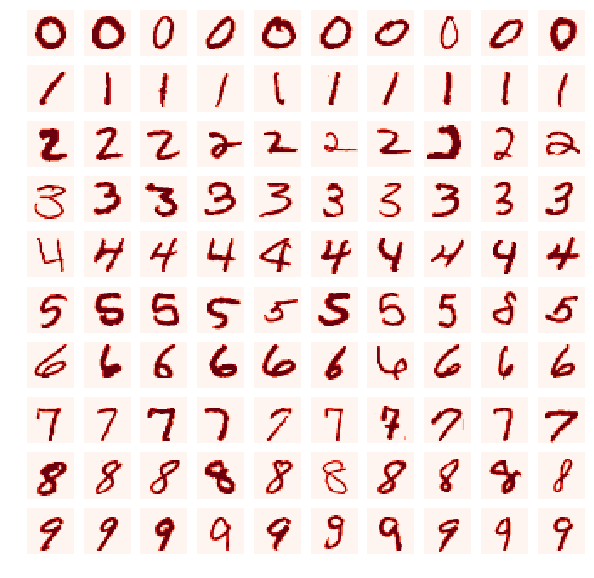

In [3]:
data_file='train.csv'
label_col='label'
num_classes=10
img_rows=28
img_cols=28

# Define layers to include in the network
# recommend giving each layer a meaningful name
layers = [
          Conv2D(10, kernel_size=(5, 5), 
                          activation='relu',name='Conv1',
                          input_shape=(img_rows, img_cols, 1)),
          Conv2D(15, kernel_size=(5, 5), 
                          activation='relu',name='Conv2'),
          Conv2D(20, kernel_size=(3, 3), 
                          activation='relu',name='Conv3'),  
          Conv2D(25, kernel_size=(3, 3), 
                          activation='relu',name='Conv4'),    
          MaxPool2D(pool_size=(2, 2), strides=2,
                          name='Pool1'),
          Flatten(name='Flatten'),
          Dense(50, activation='relu',name='Dense1'),   
          ######################################################
          # BE CAREFUL IF CHANGING OUTPUT LAYER
          Dense(num_classes, activation='softmax',
                          name='Output')
          ######################################################
        ]

nvis = NetworkVisualiser(layers, data_file=data_file, label_col=label_col, 
                         num_classes=num_classes, img_rows=img_rows, img_cols=img_cols)

nvis.show_images()

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 147s 4ms/step - loss: 0.2840 - acc: 0.9146 - val_loss: 0.0933 - val_acc: 0.9702
Epoch 2/3
33600/33600 [==============================] - 138s 4ms/step - loss: 0.0791 - acc: 0.9751 - val_loss: 0.0638 - val_acc: 0.9810
Epoch 3/3
33600/33600 [==============================] - 141s 4ms/step - loss: 0.0574 - acc: 0.9830 - val_loss: 0.0508 - val_acc: 0.9843
Calculating output at each layer...
Conv1 layer has shape (42000, 24, 24, 10)
Conv2 layer has shape (42000, 20, 20, 15)
Conv3 layer has shape (42000, 18, 18, 20)
Conv4 layer has shape (42000, 16, 16, 25)
Pool1 layer has shape (42000, 8, 8, 25)
Flatten layer has shape (42000, 1600)
Dense1 layer has shape (42000, 50)
Output layer has shape (42000, 10)


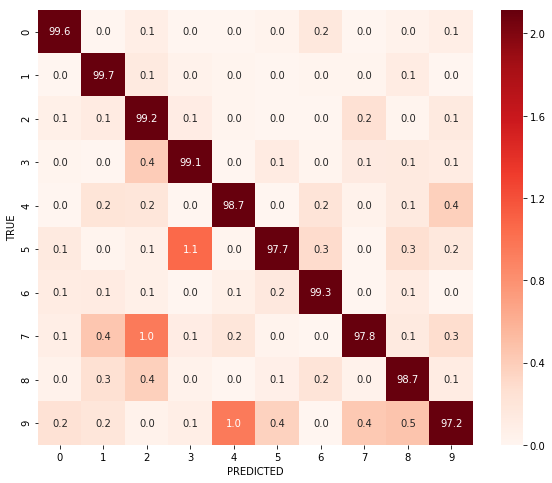

In [4]:
nvis.fit(epochs=3)
nvis.show_conf_matrix()

Calculating TSNE representations...
Input...Conv1...Conv2...Conv3...Conv4...Pool1...Flatten...Dense1...Output...Done!


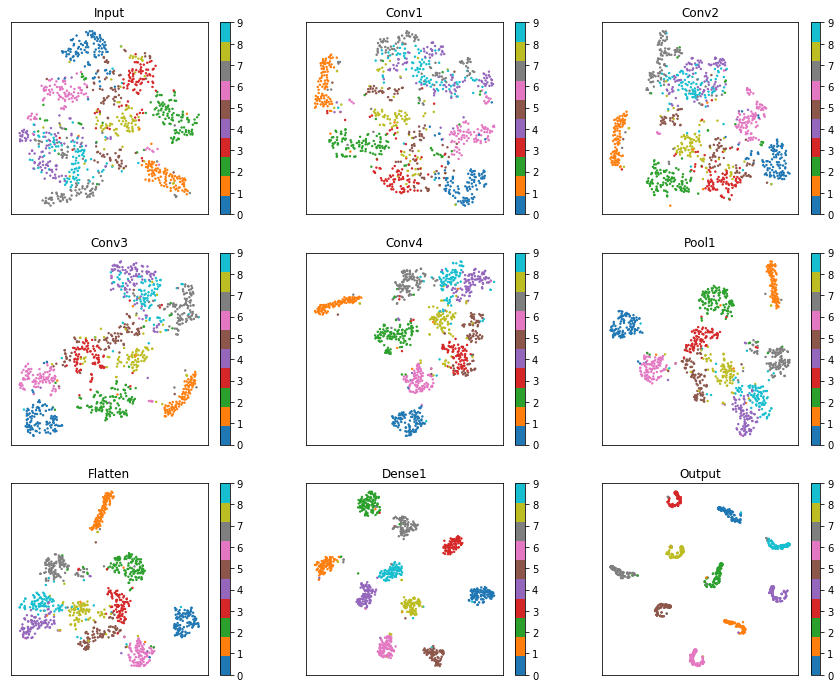

In [5]:
nvis.tsne_layers(range(1000))

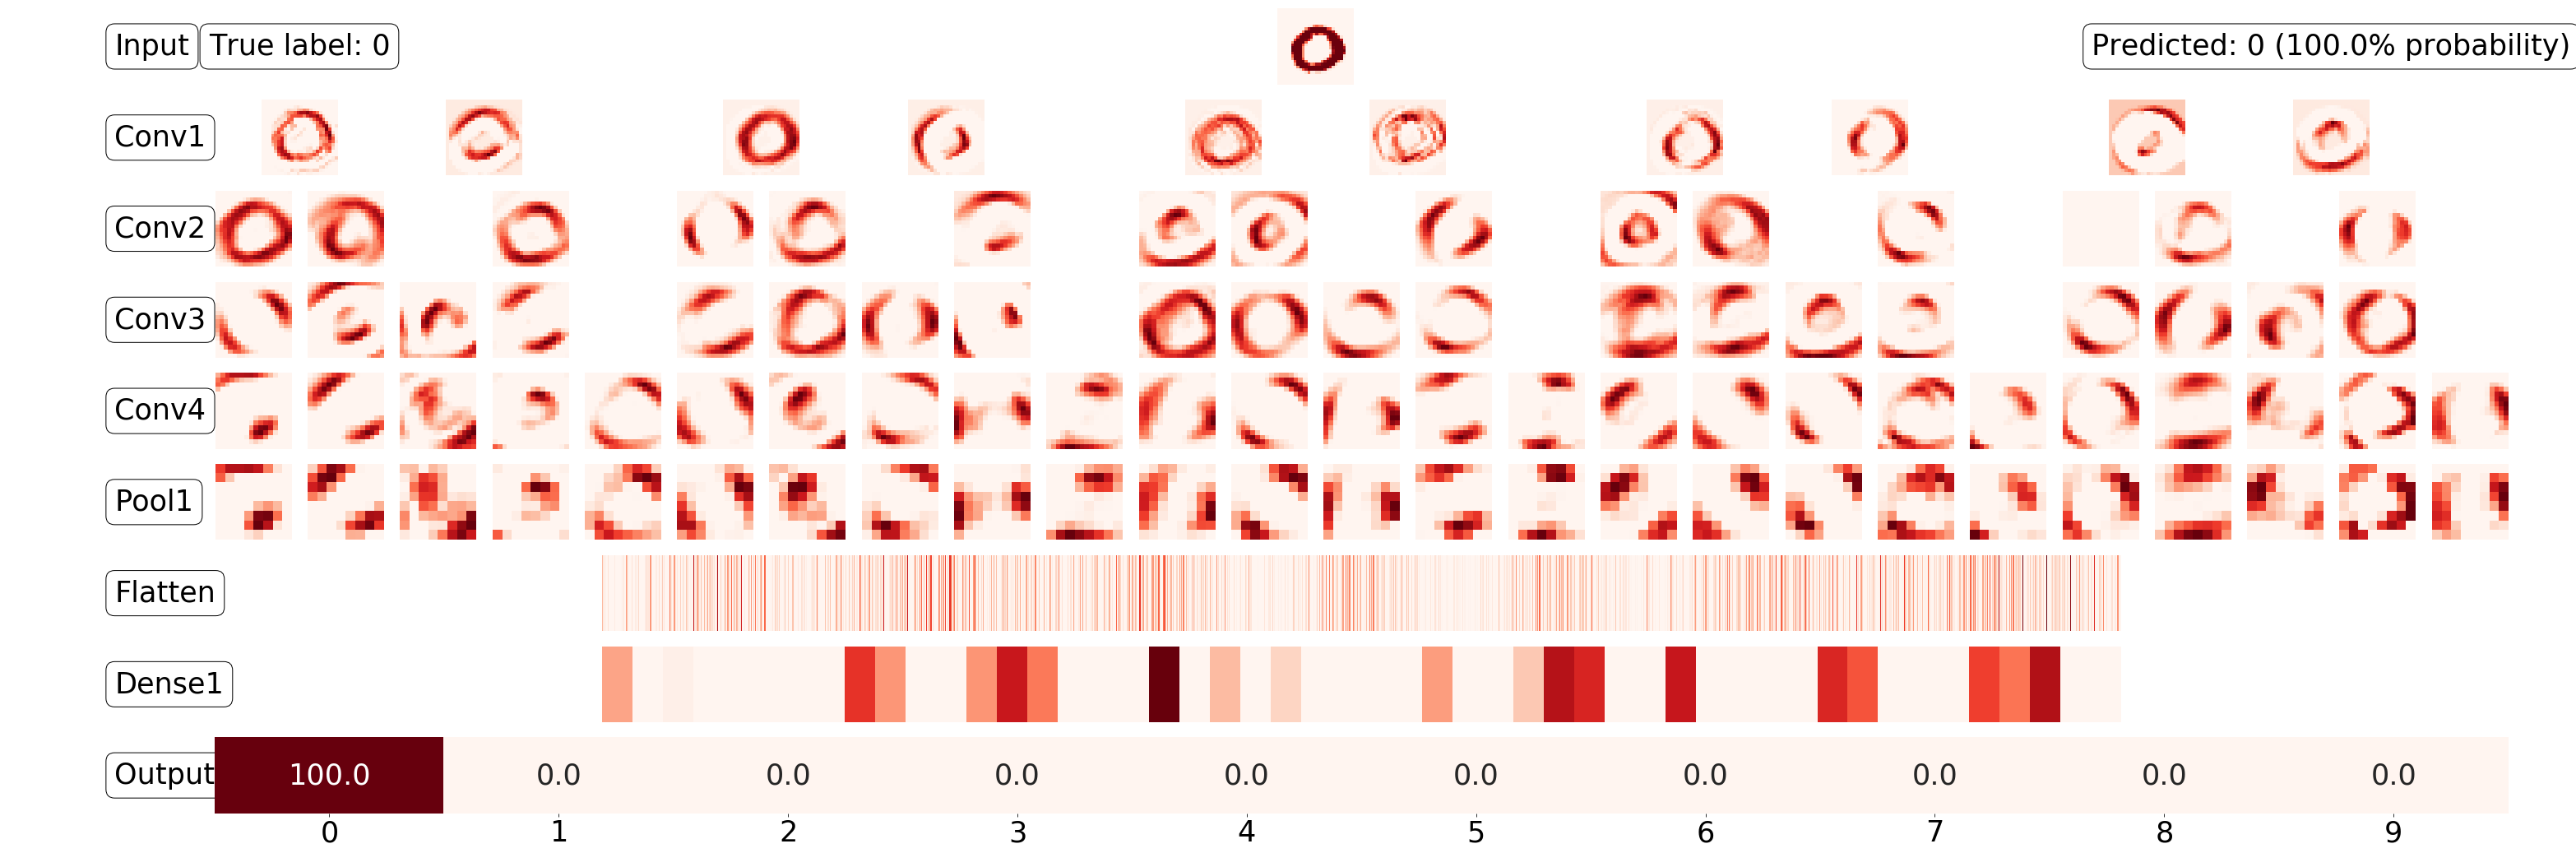

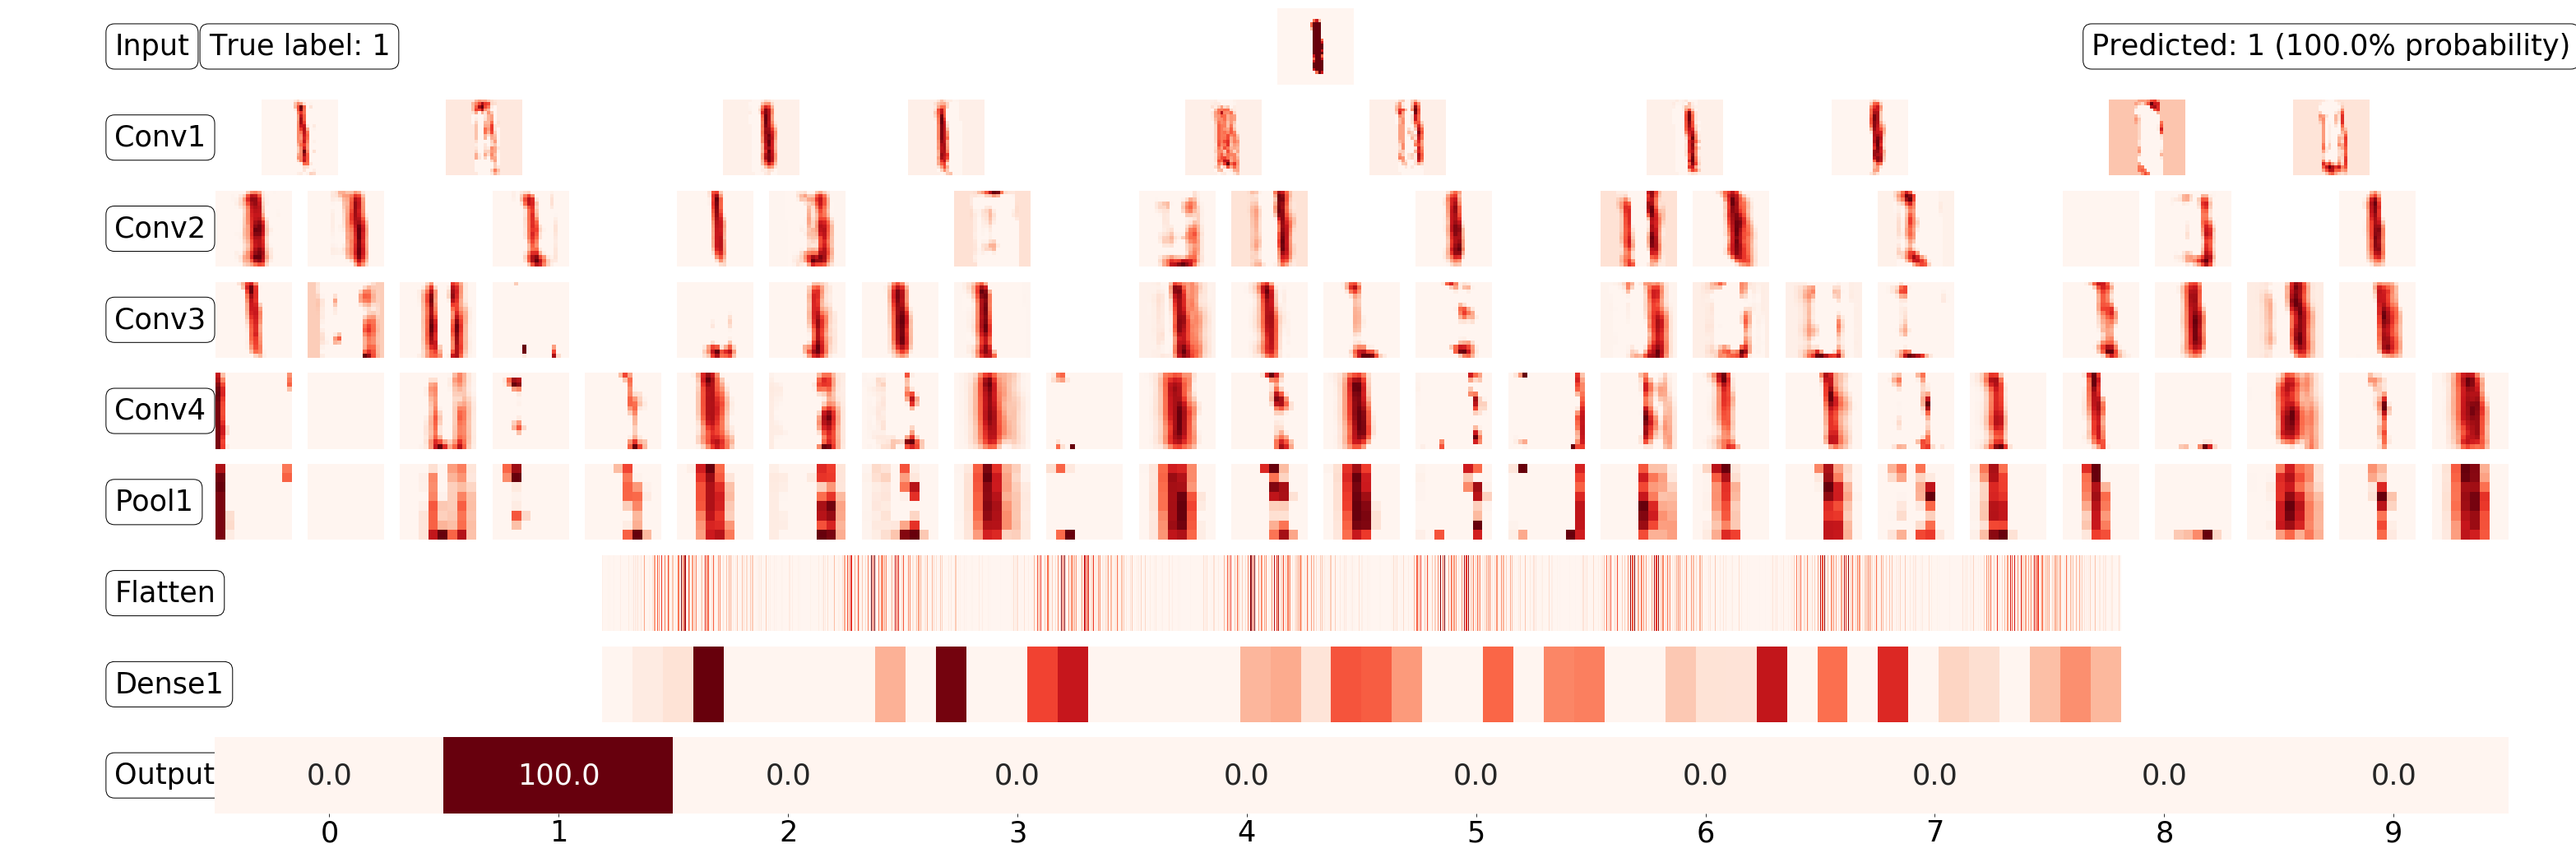

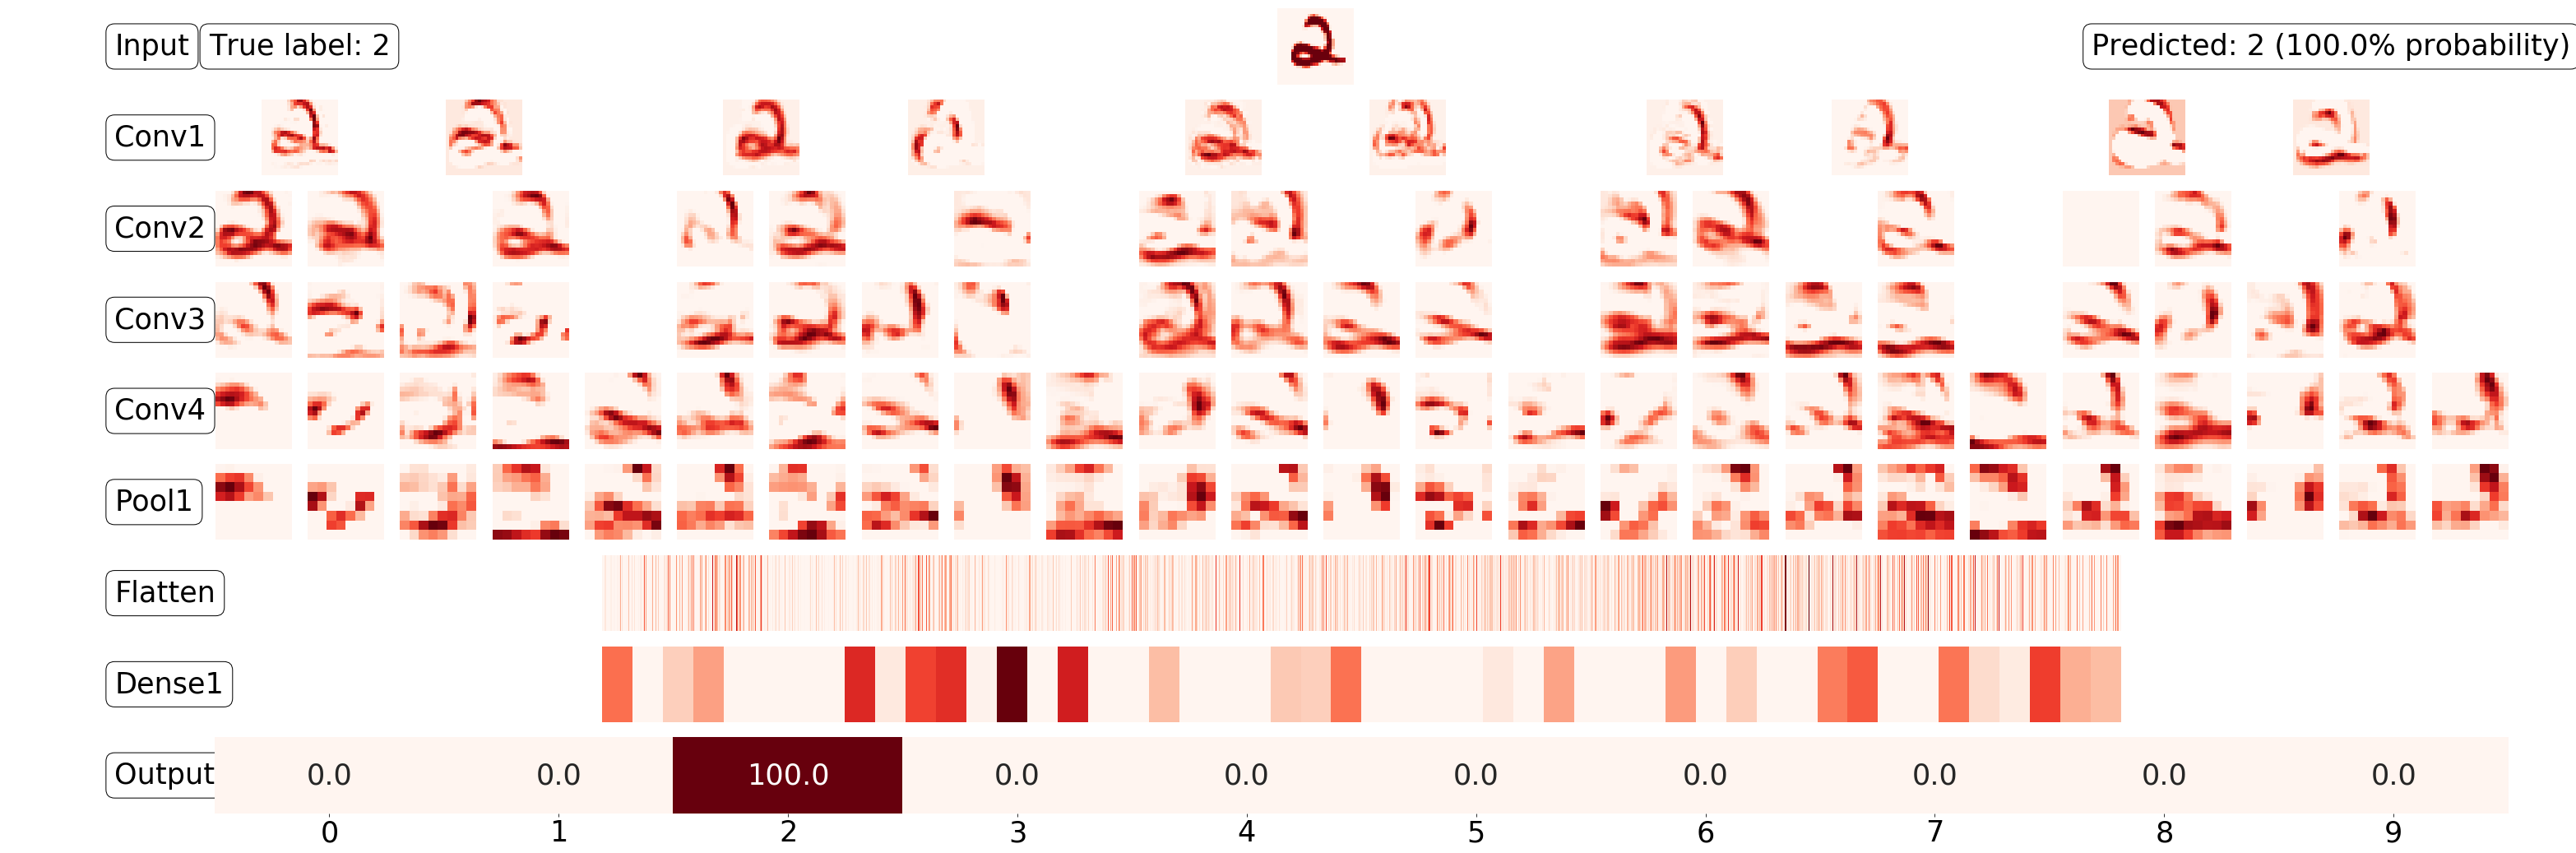

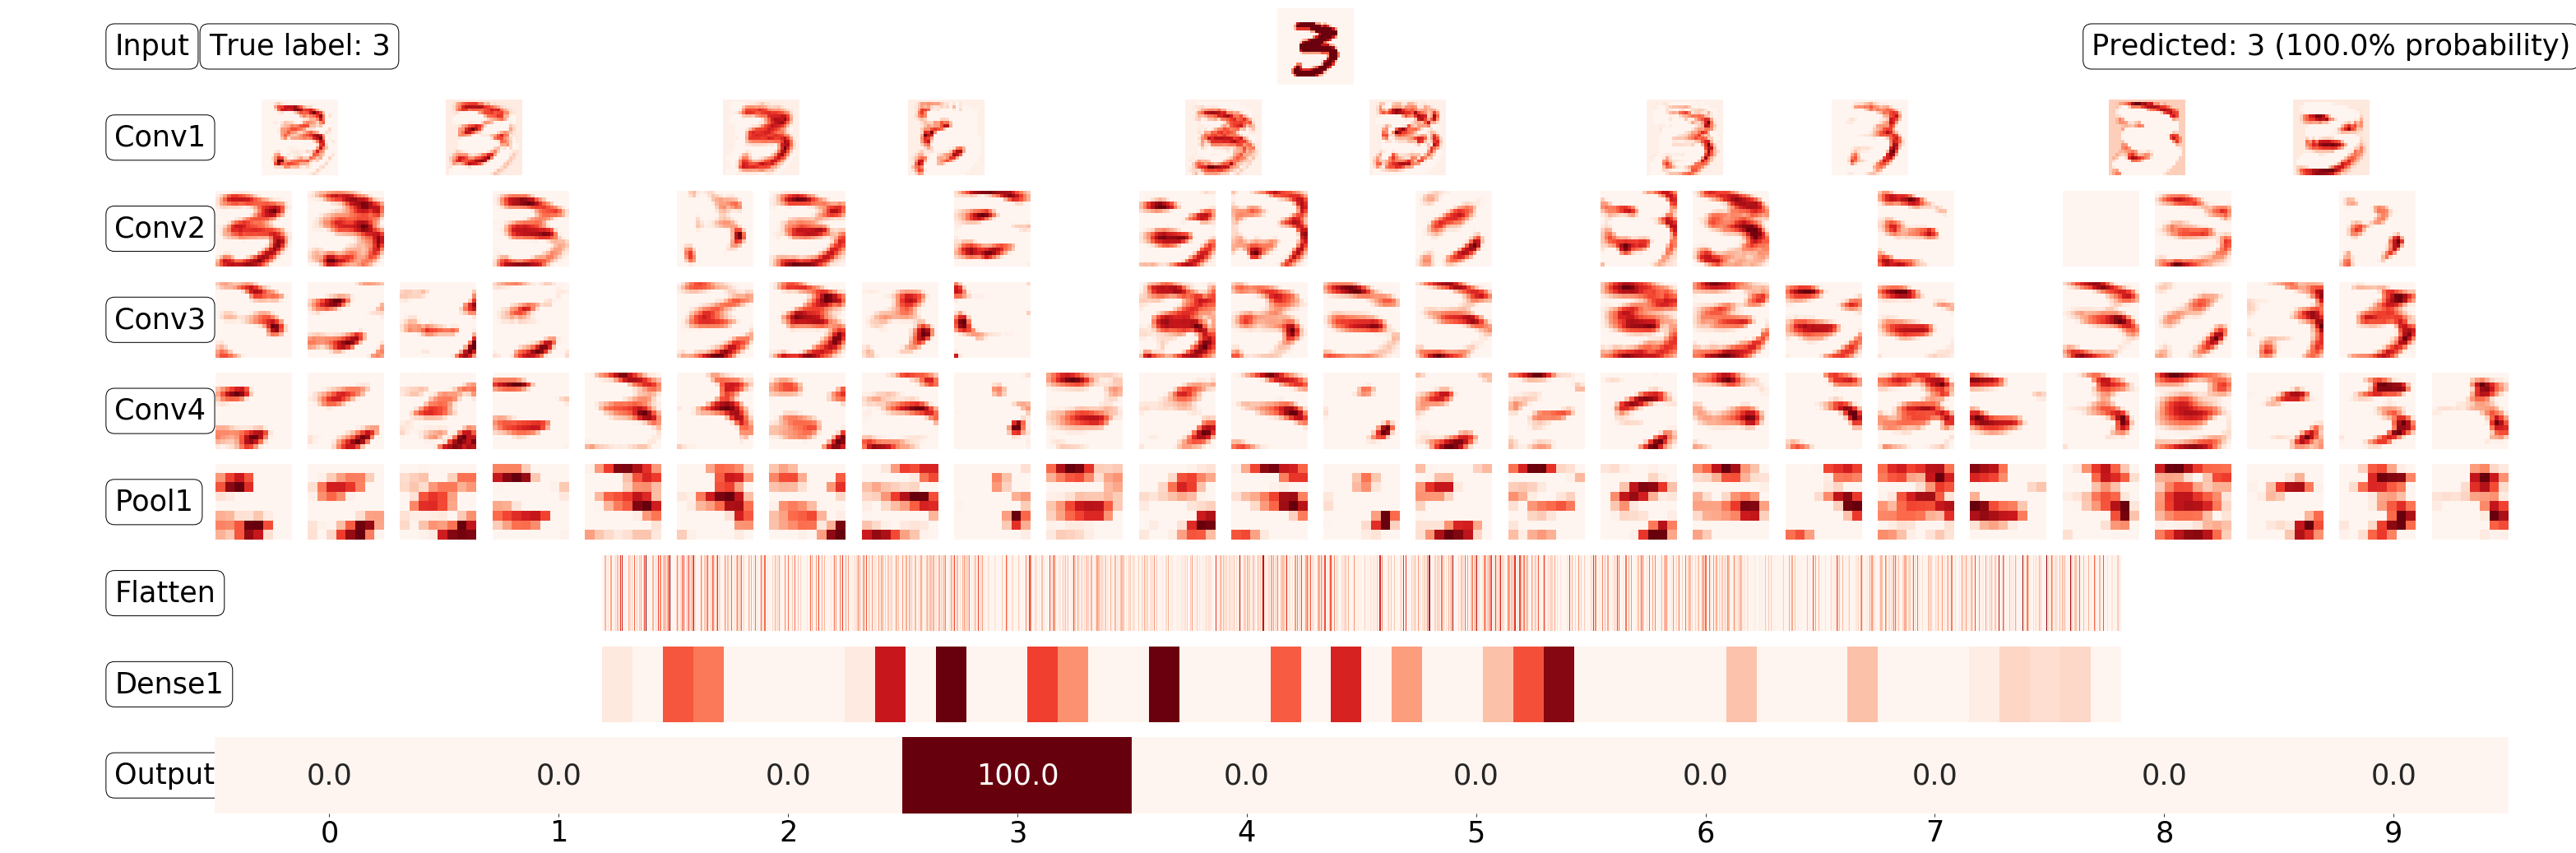

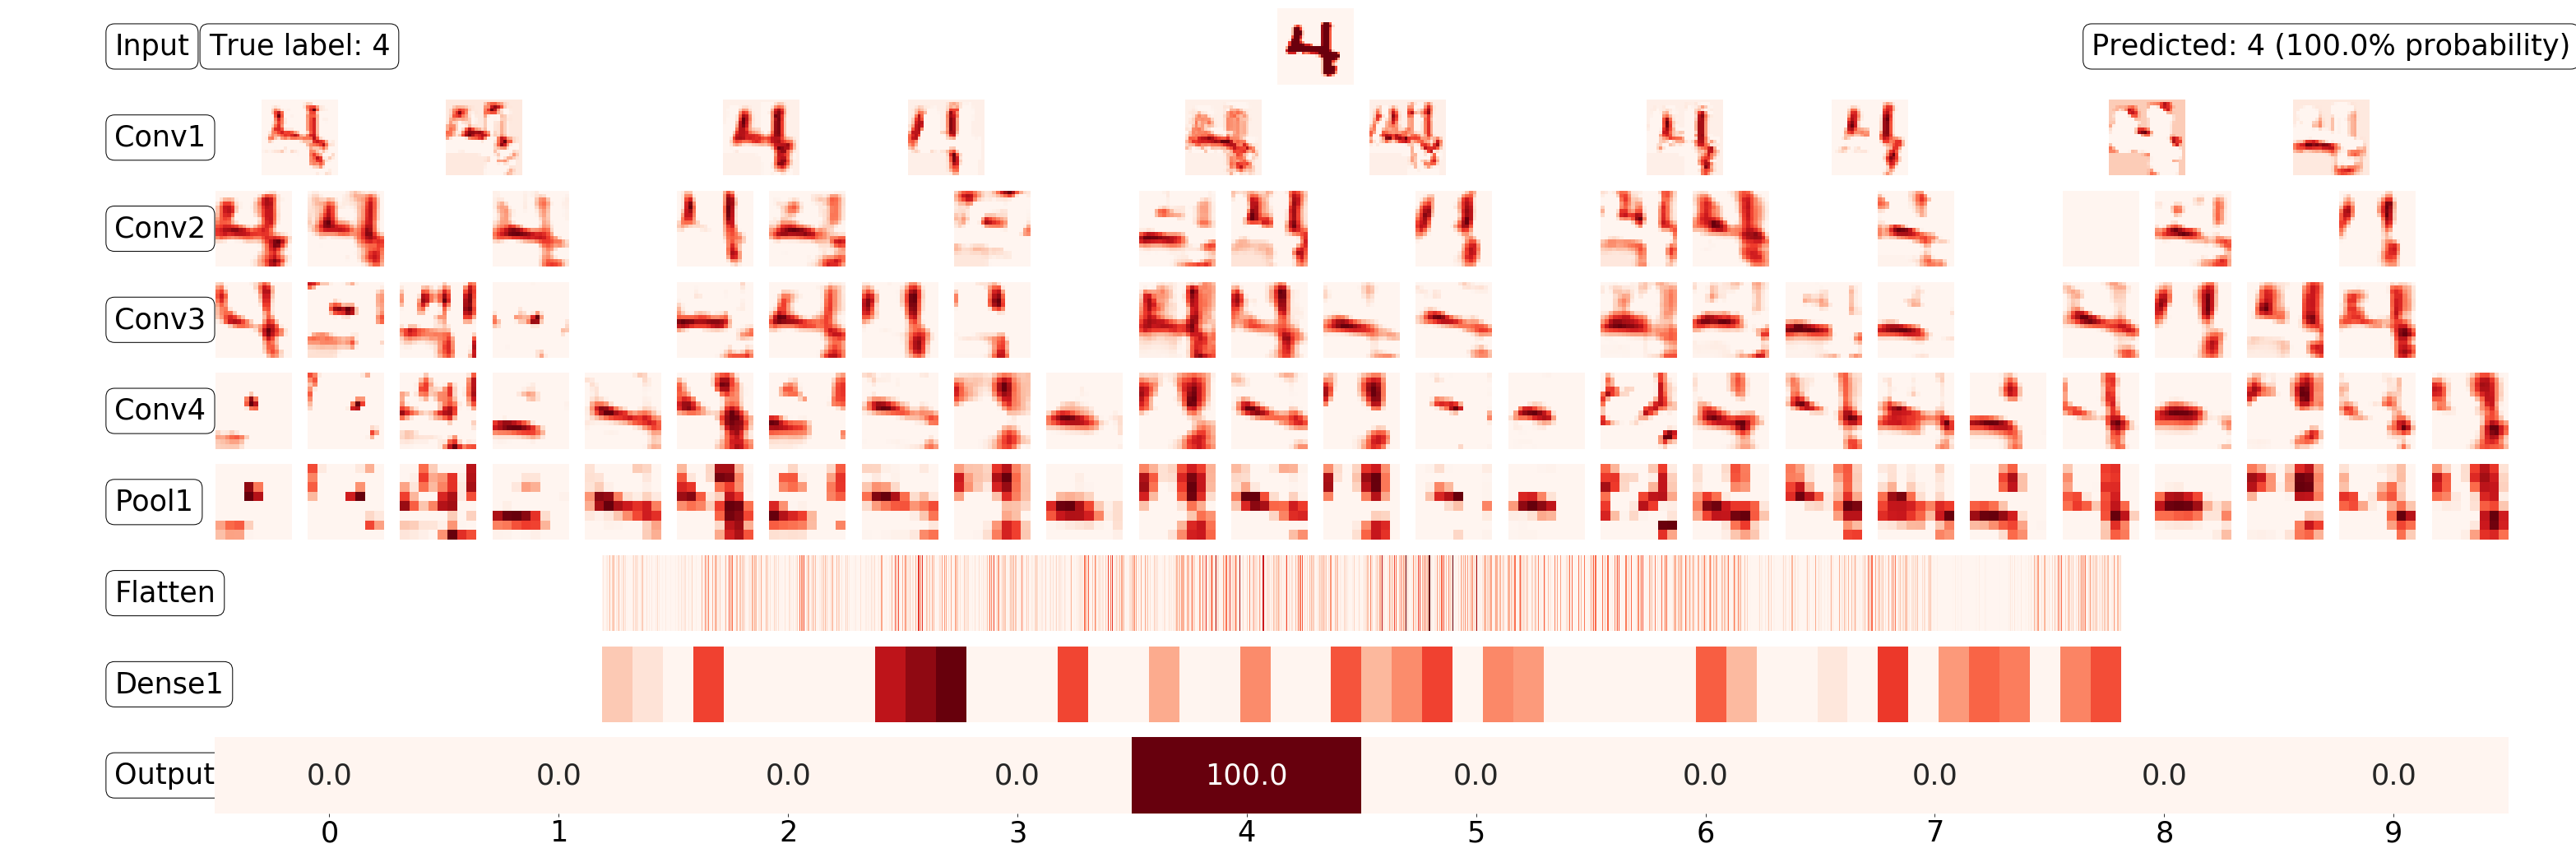

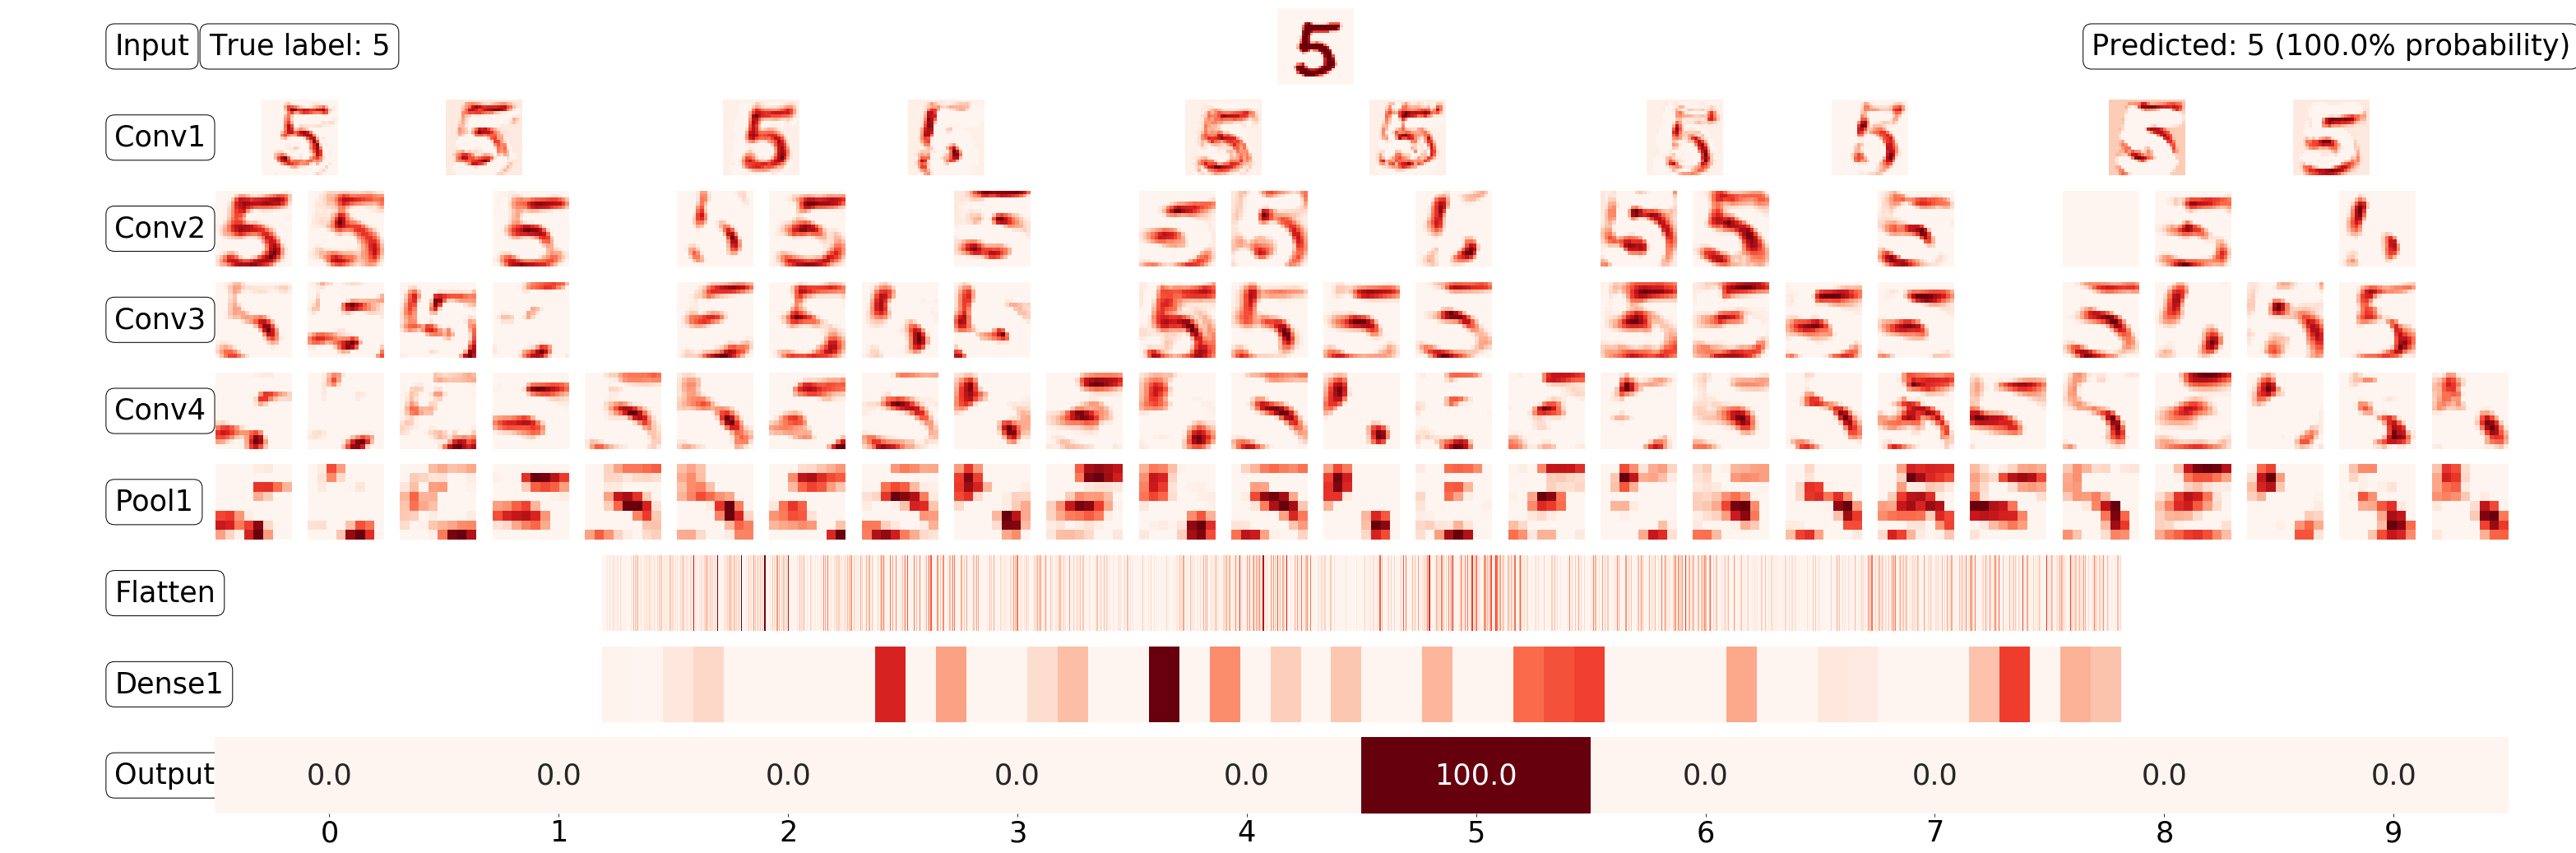

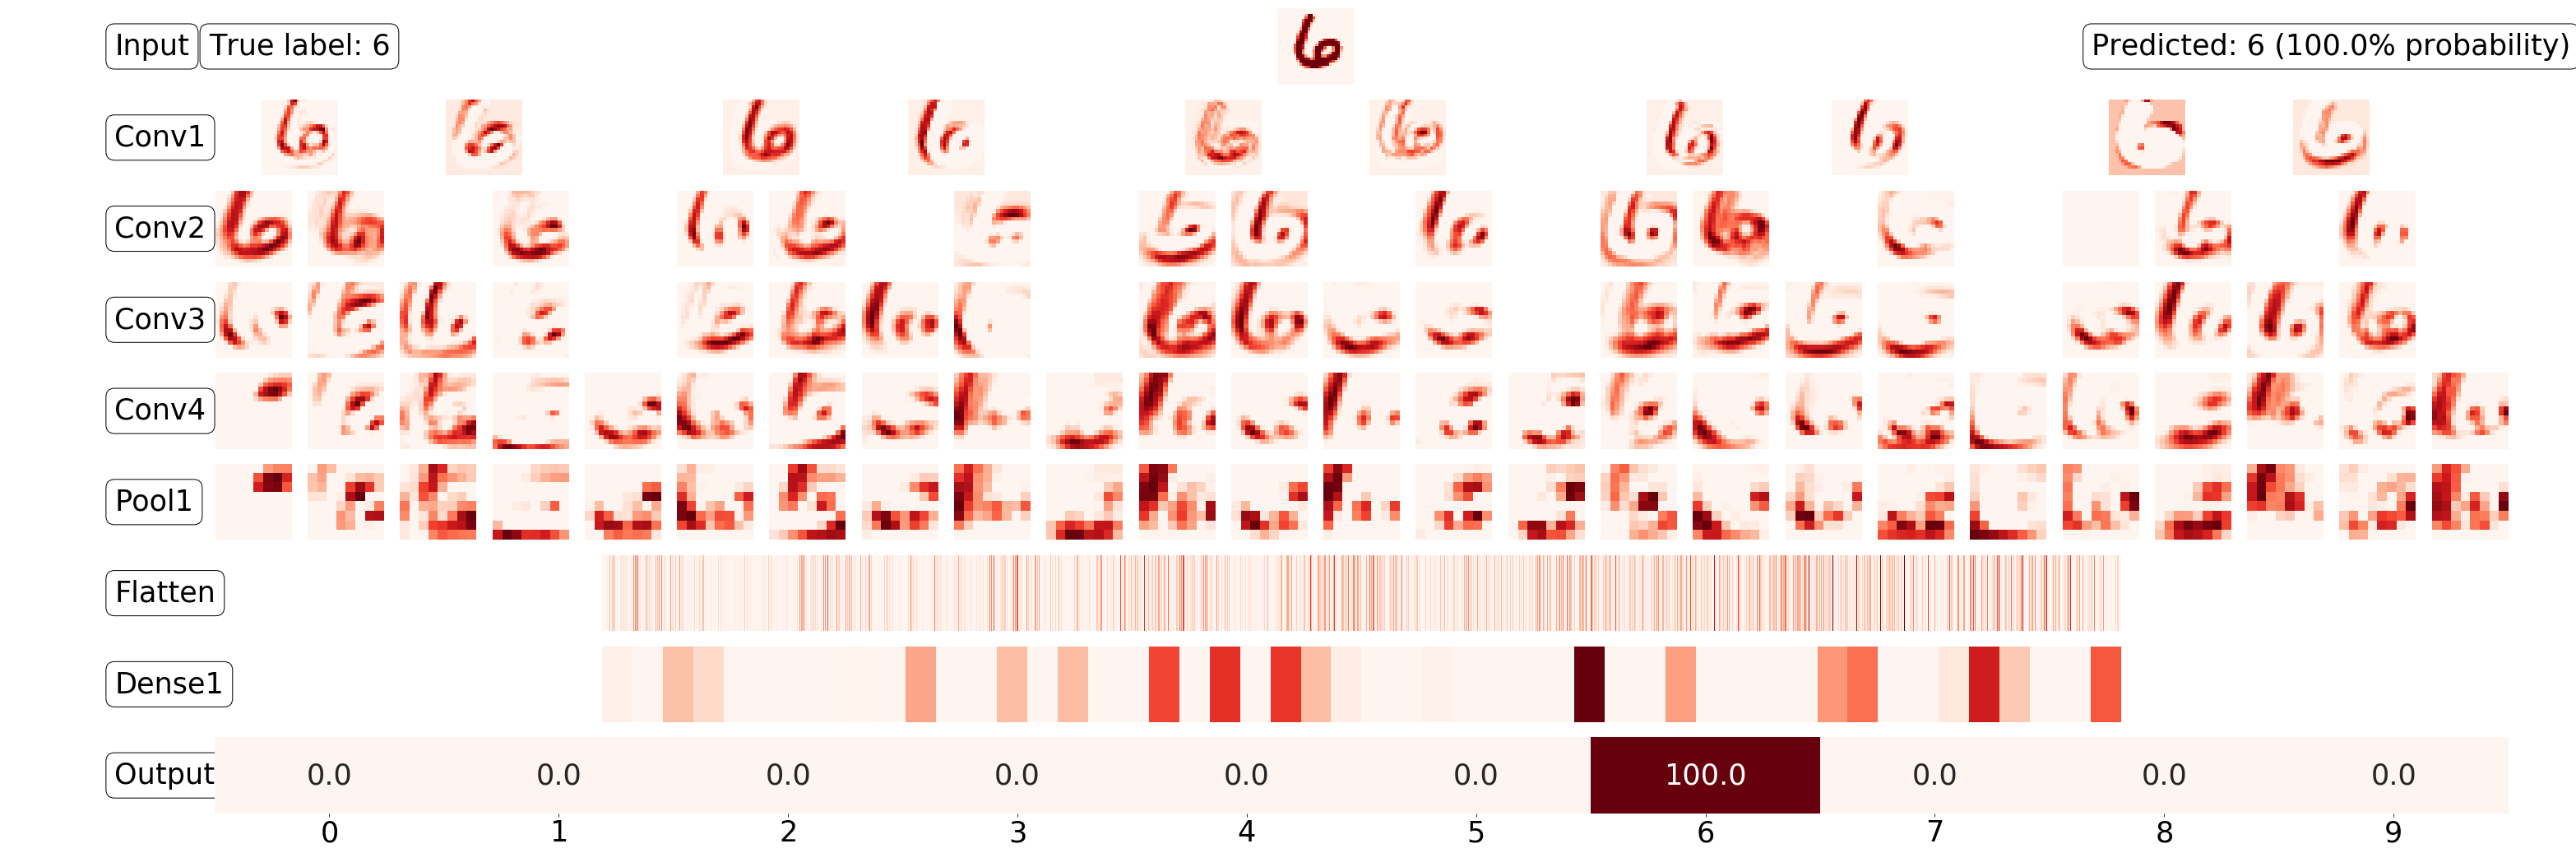

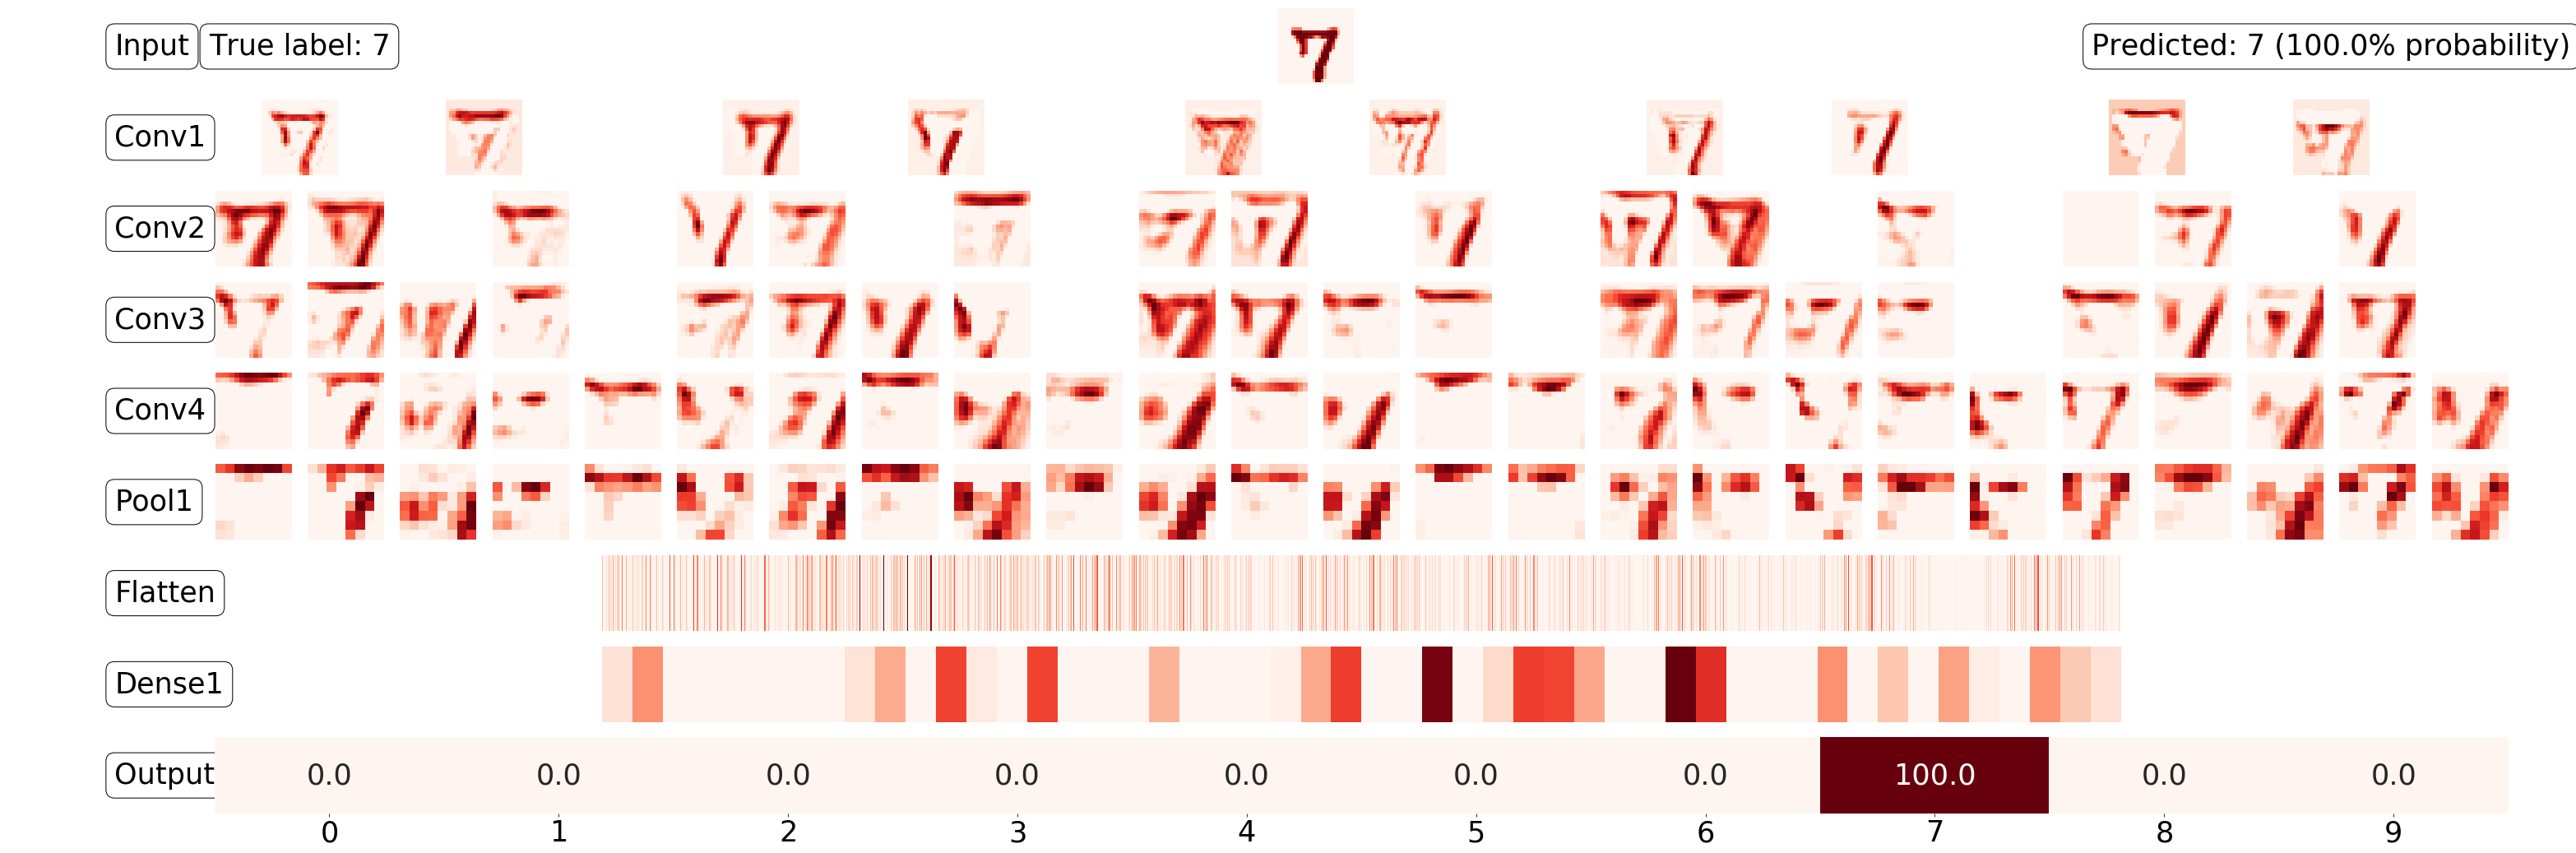

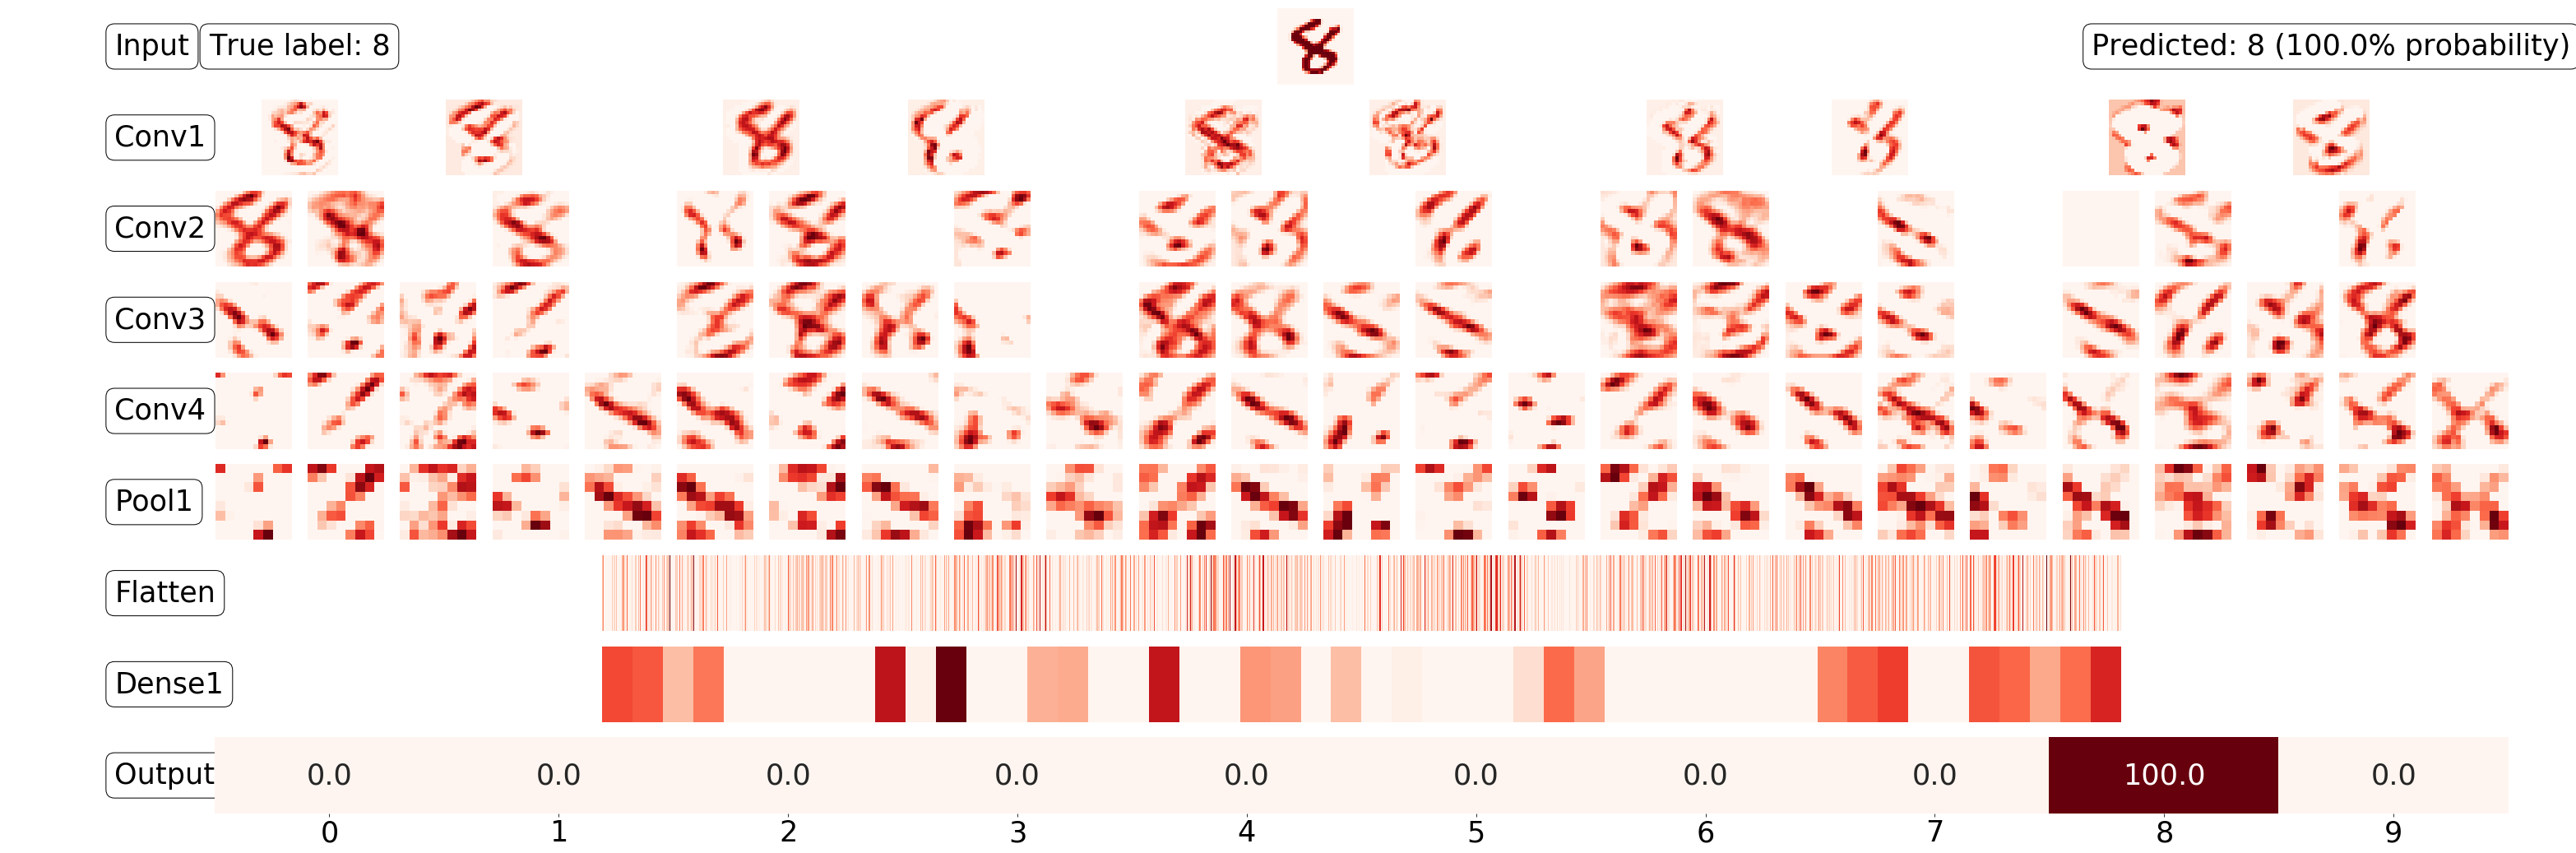

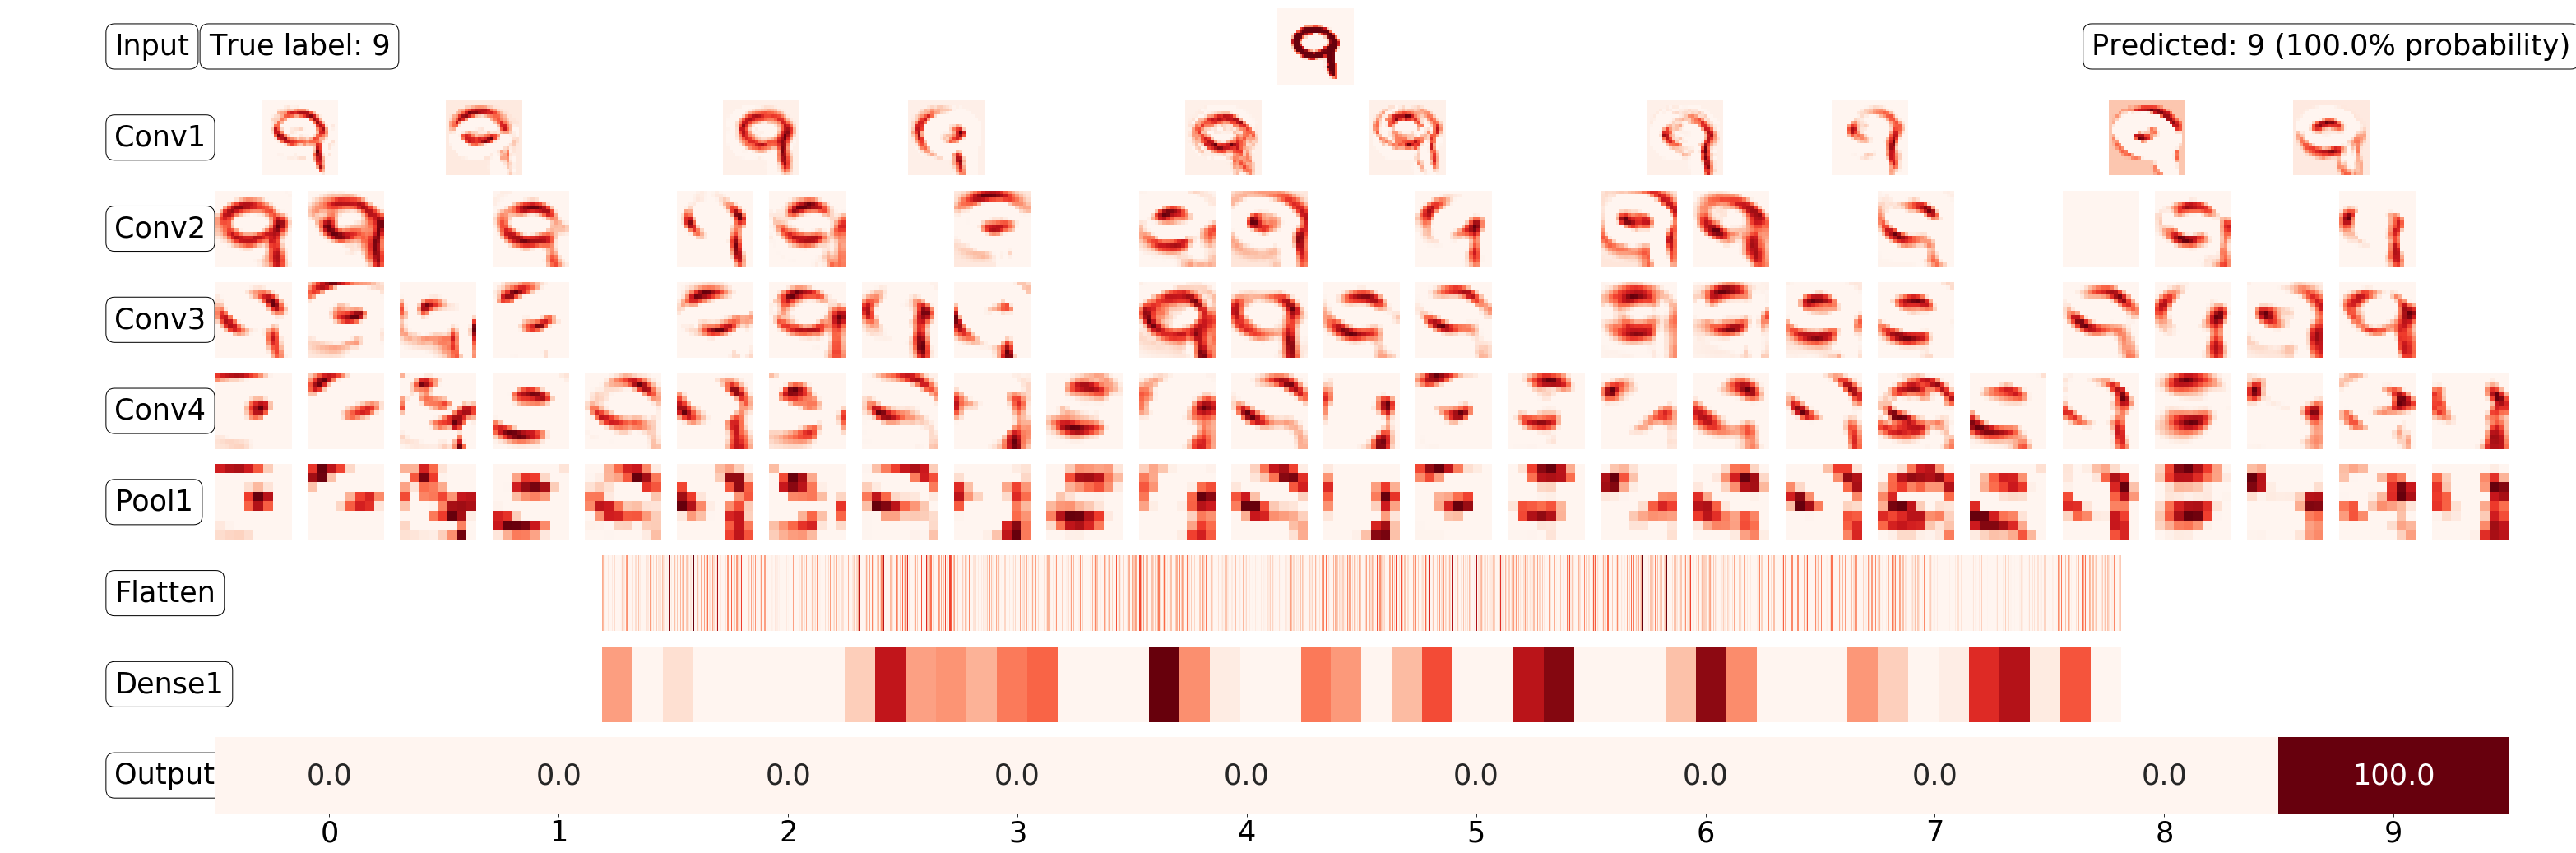

In [6]:
nvis.visualise_classbest()

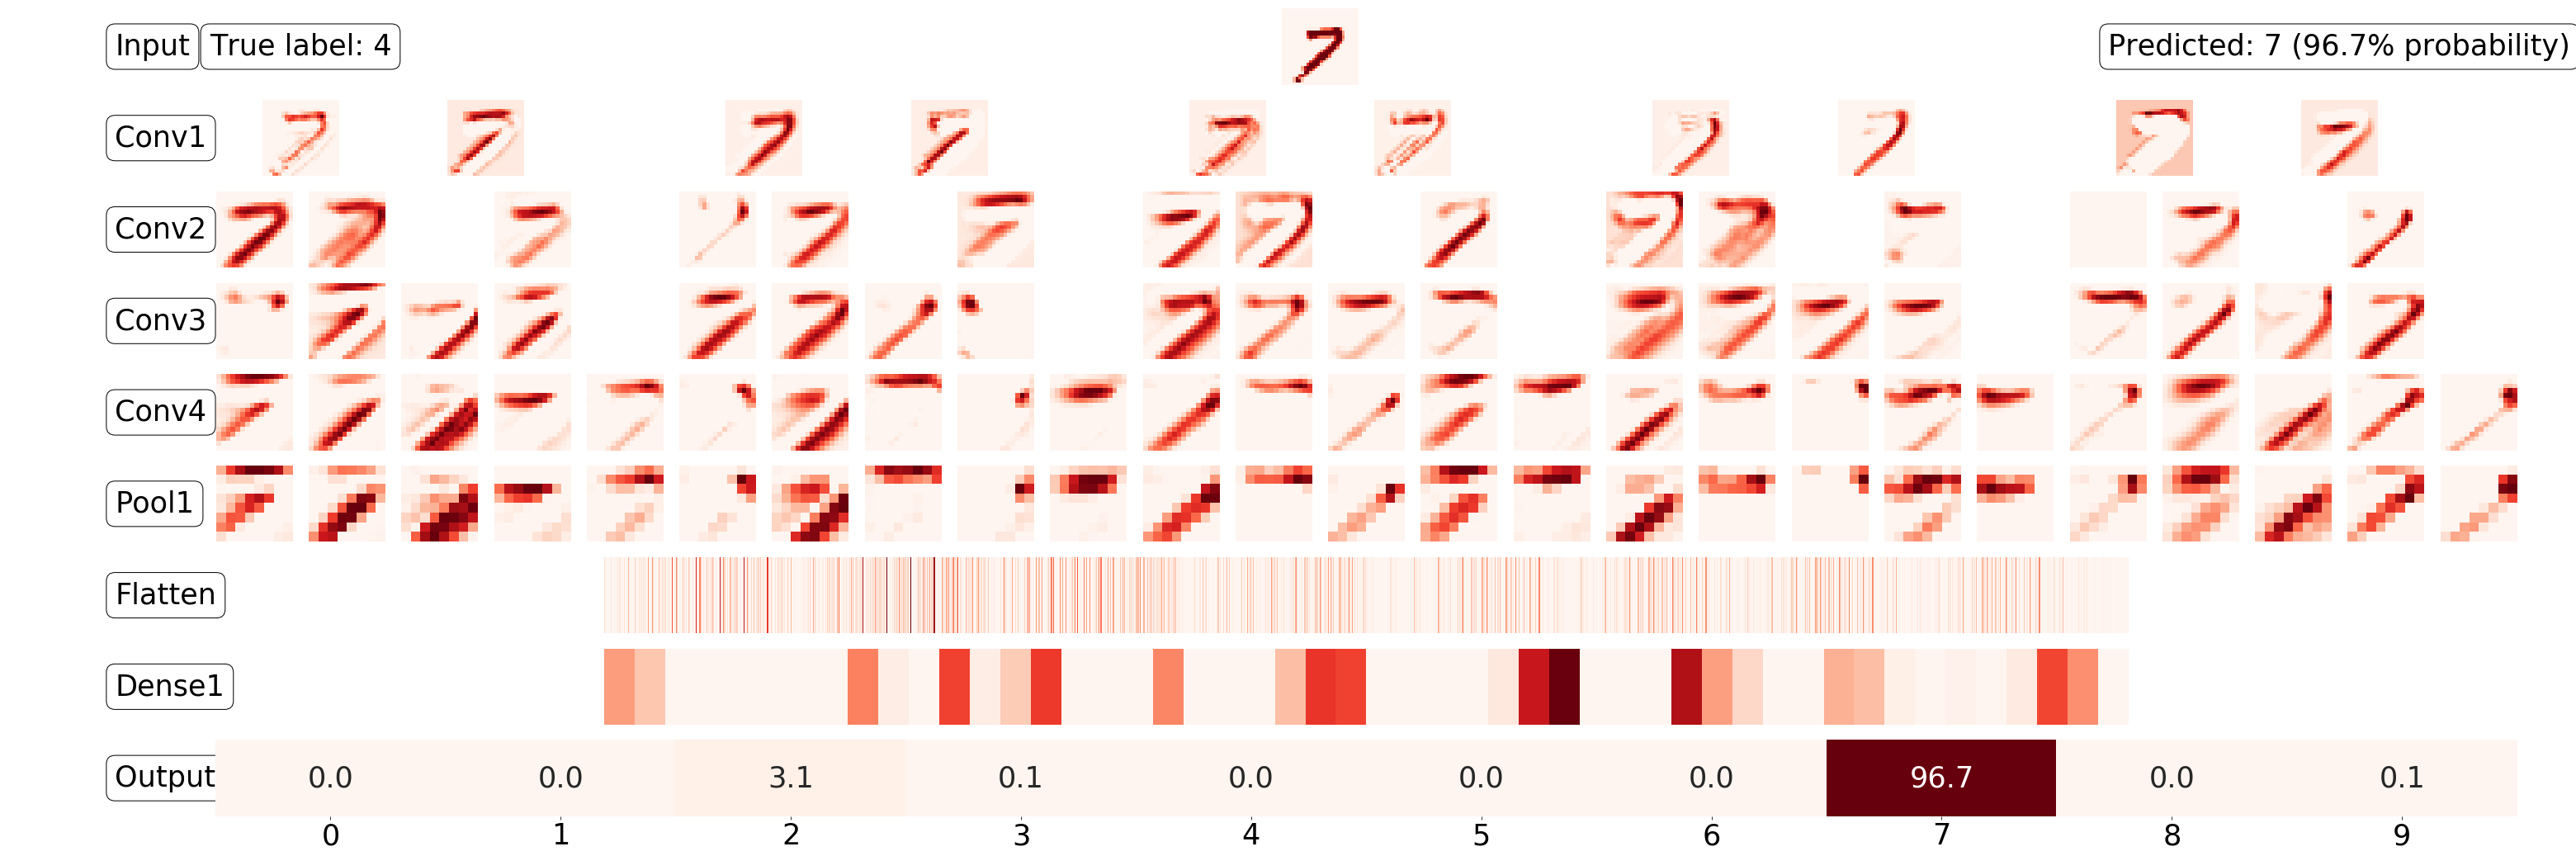

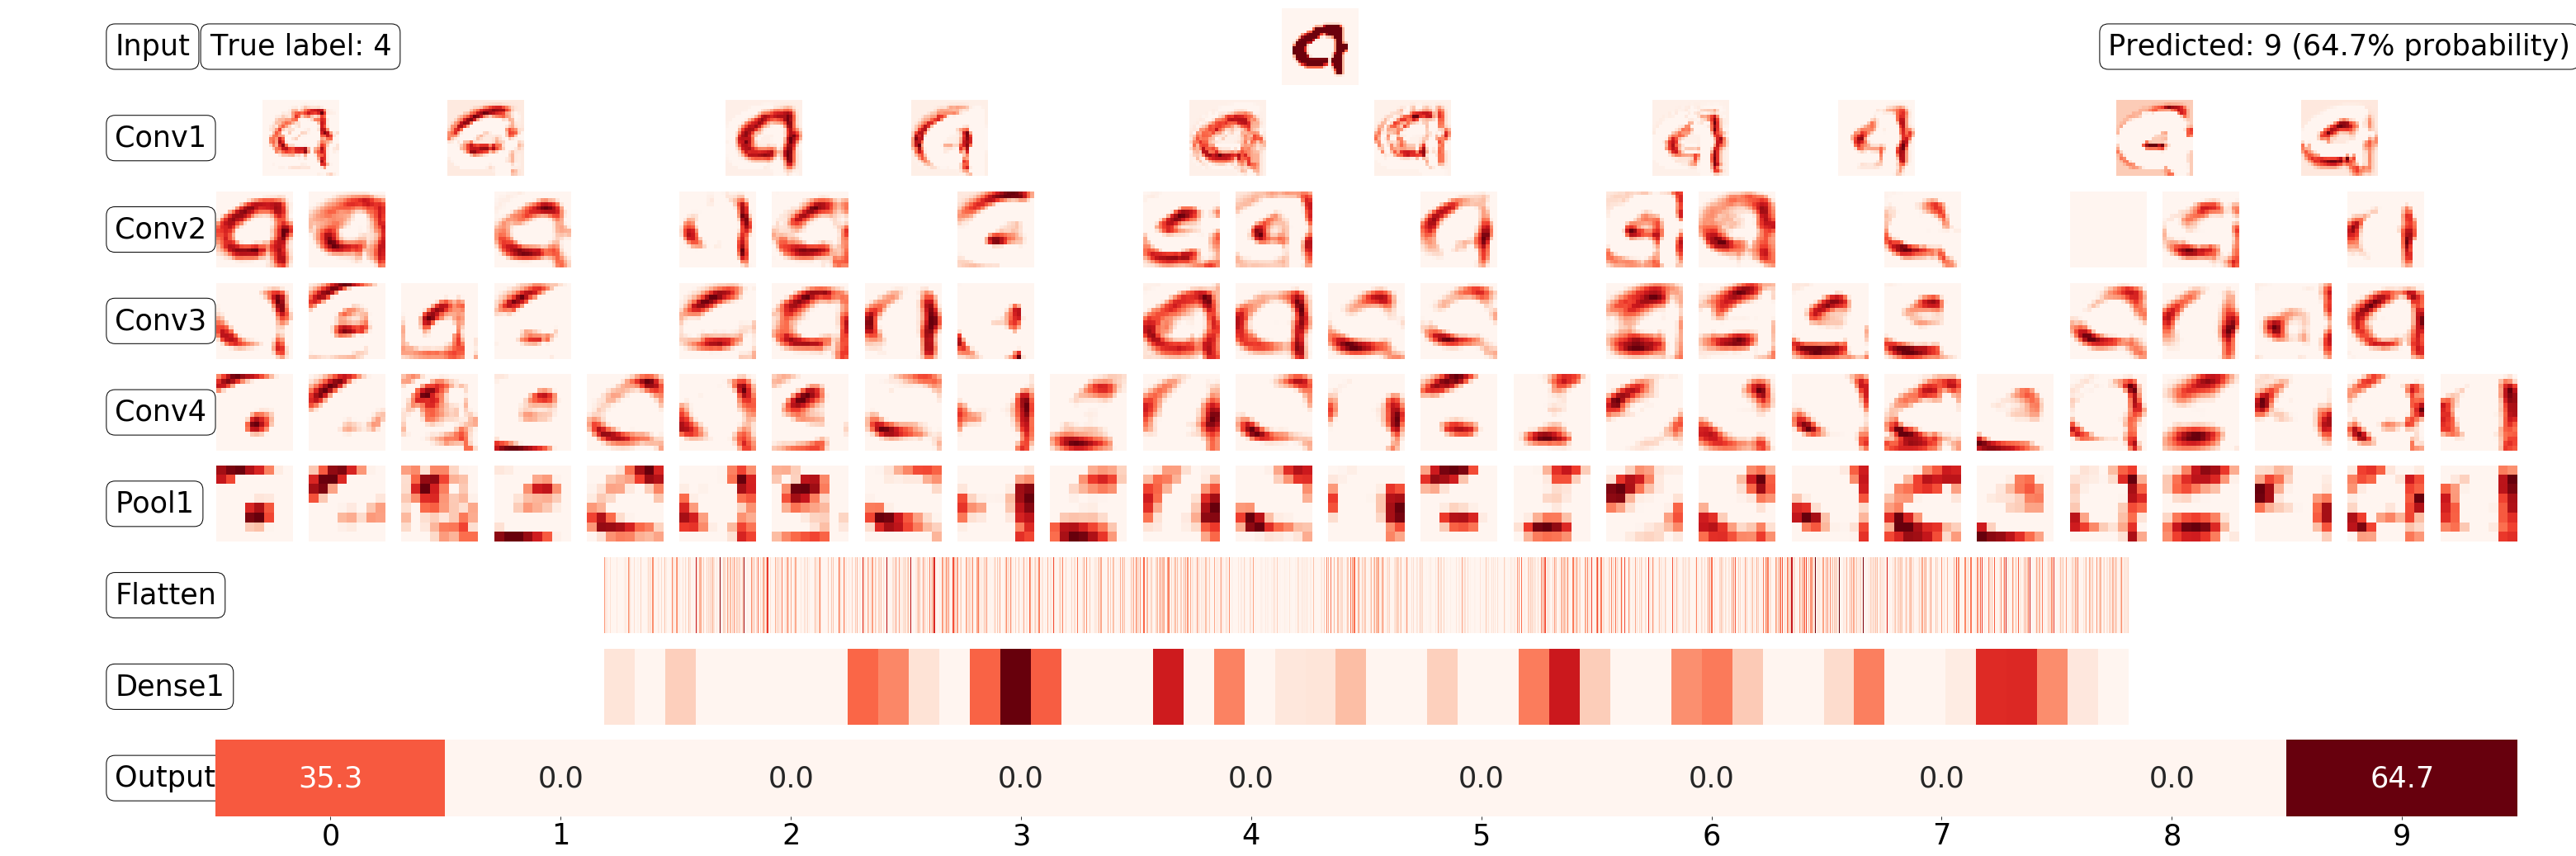

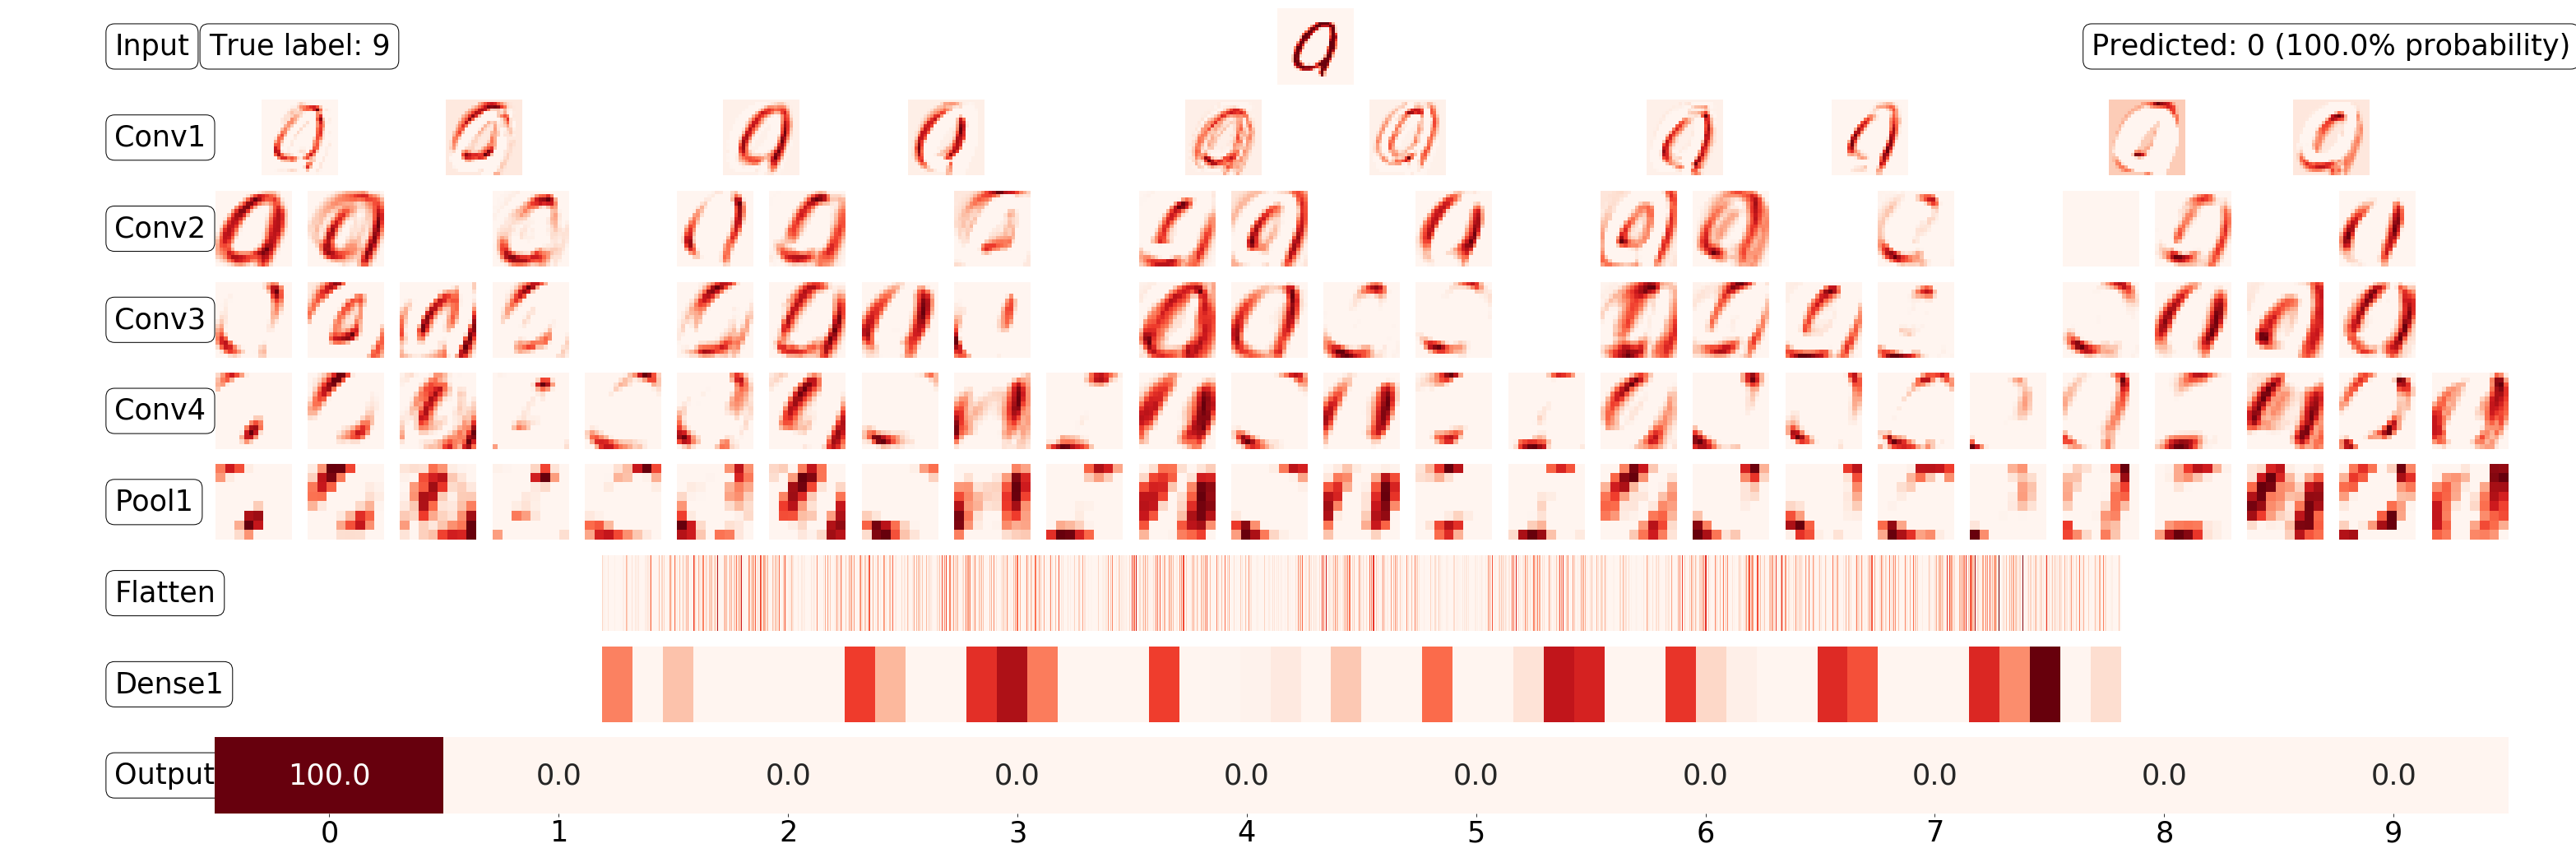

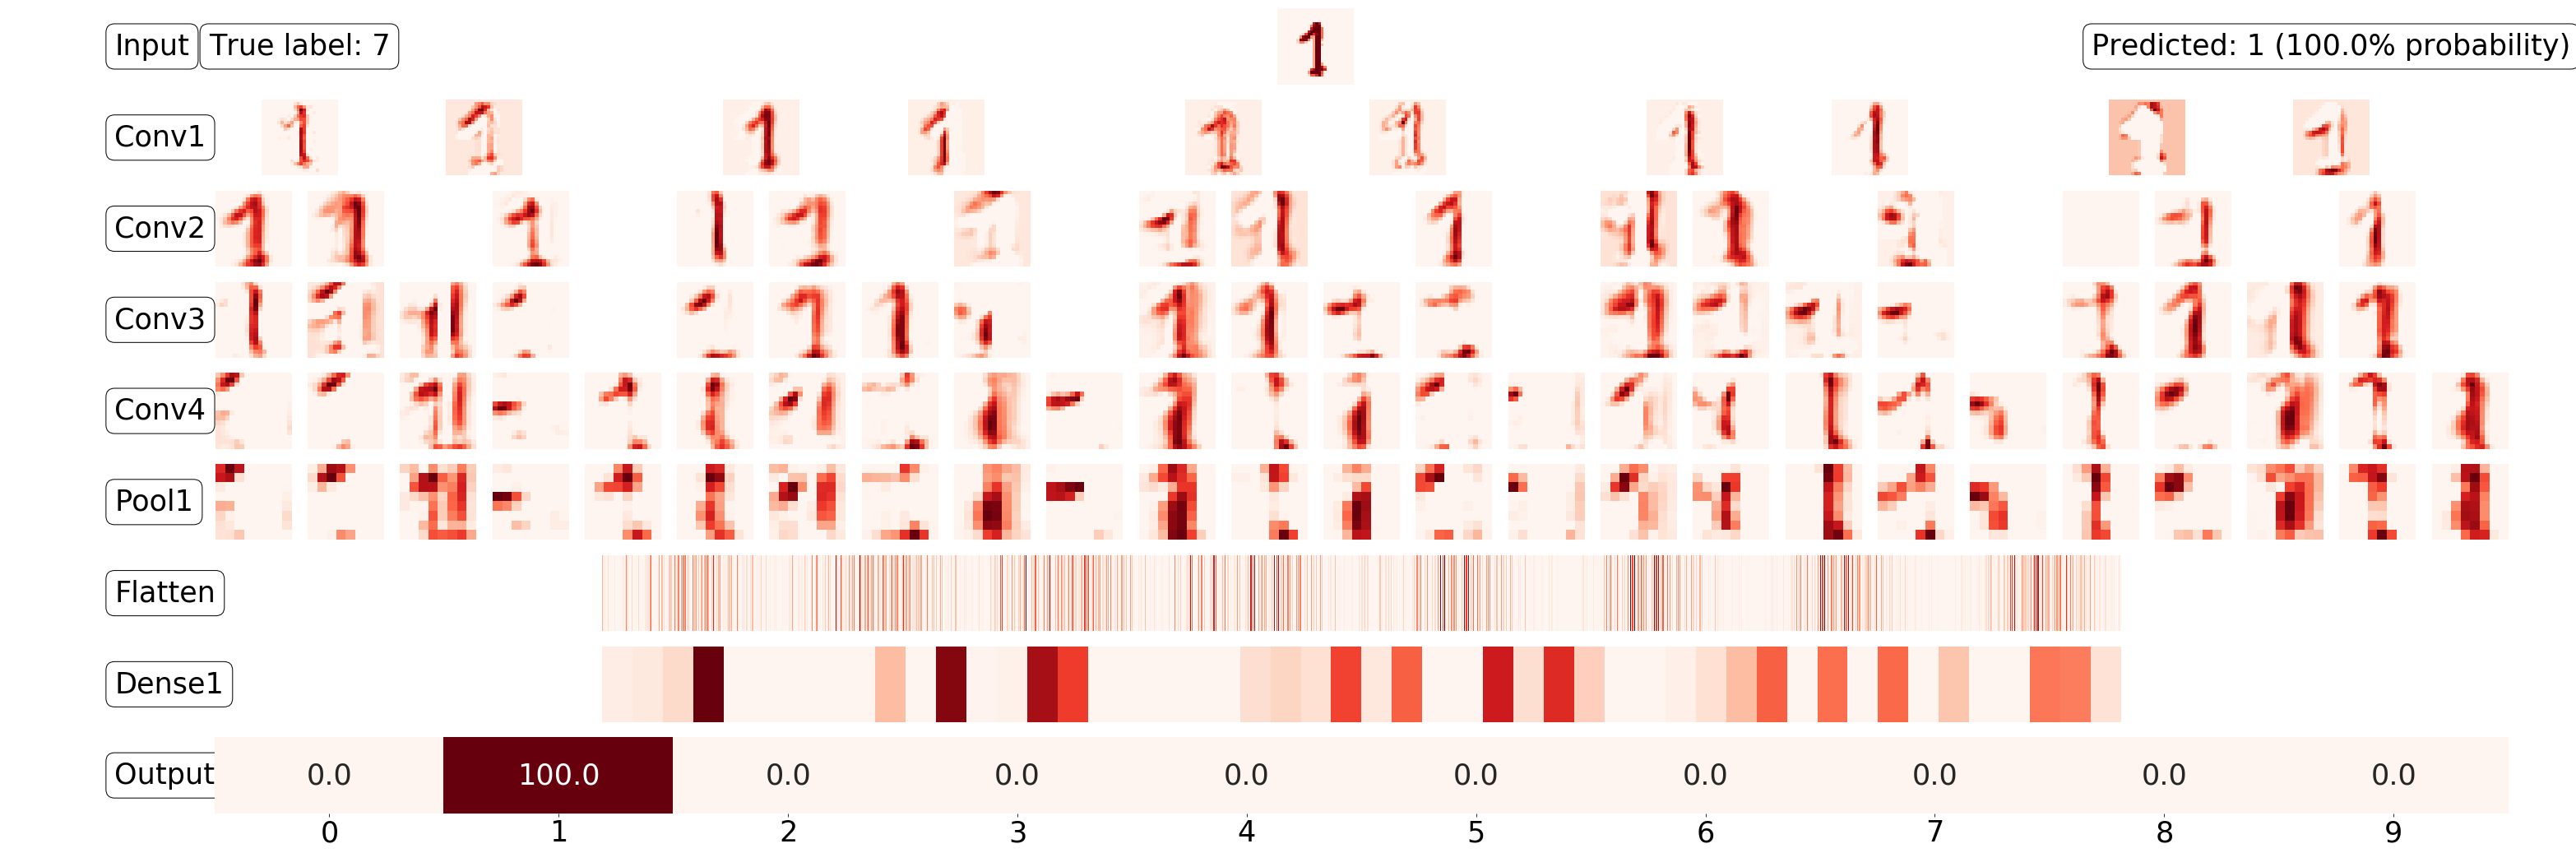

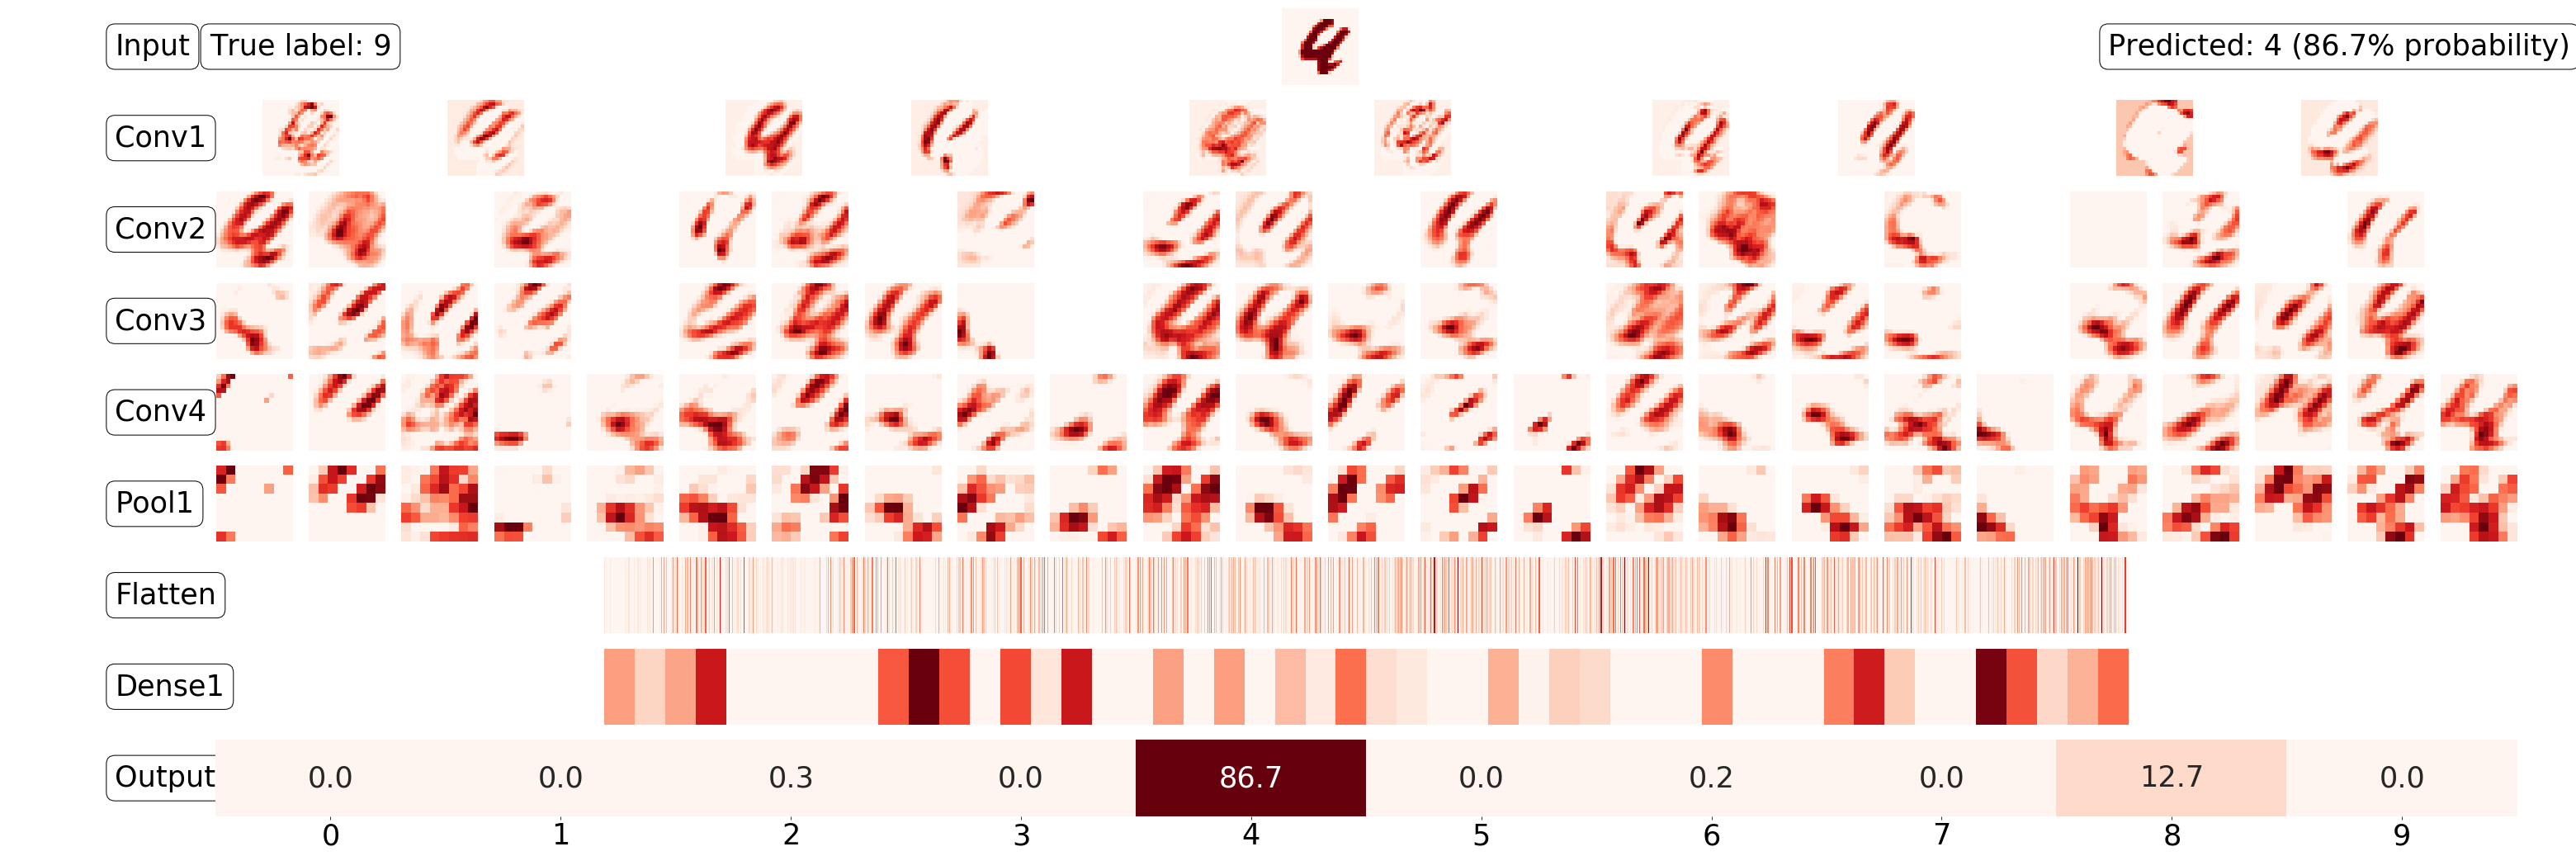

In [7]:
nvis.visualise_worst()

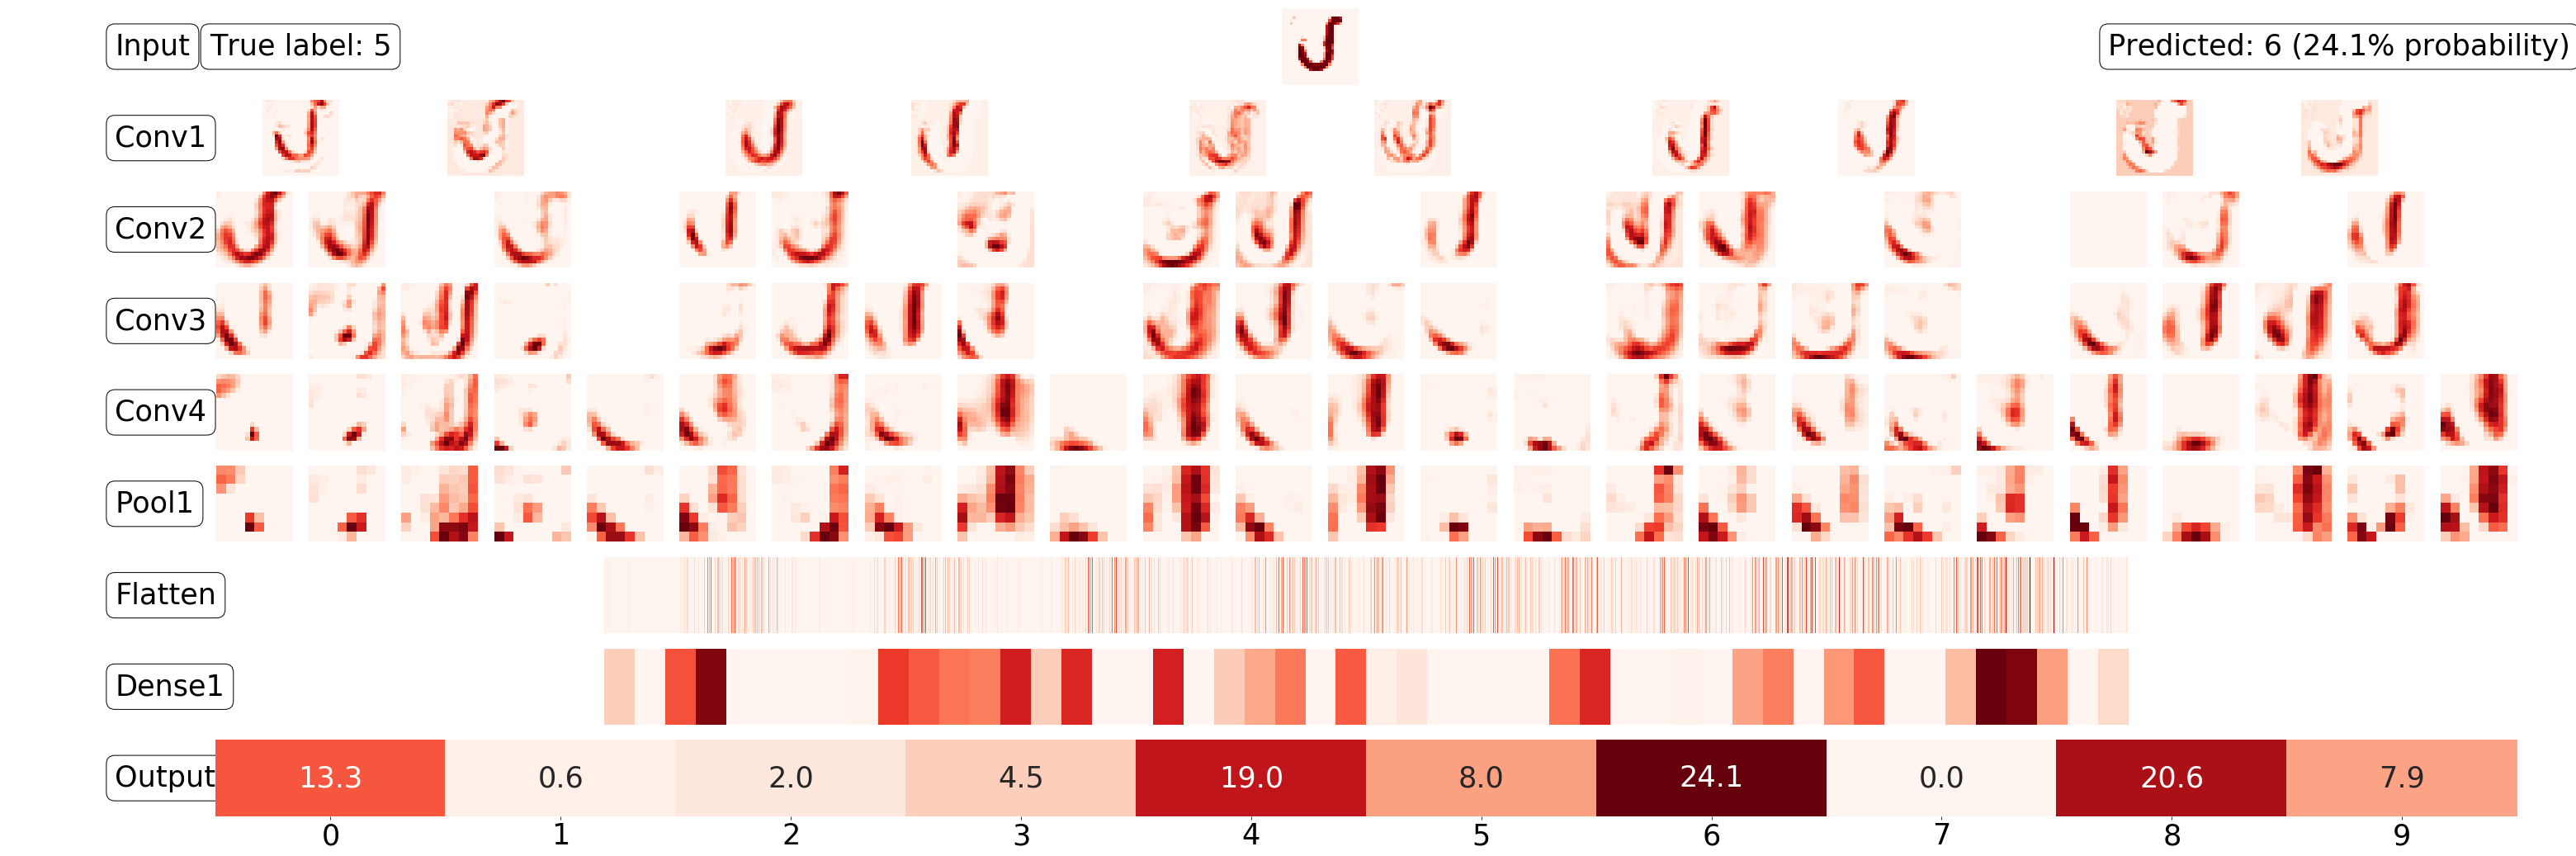

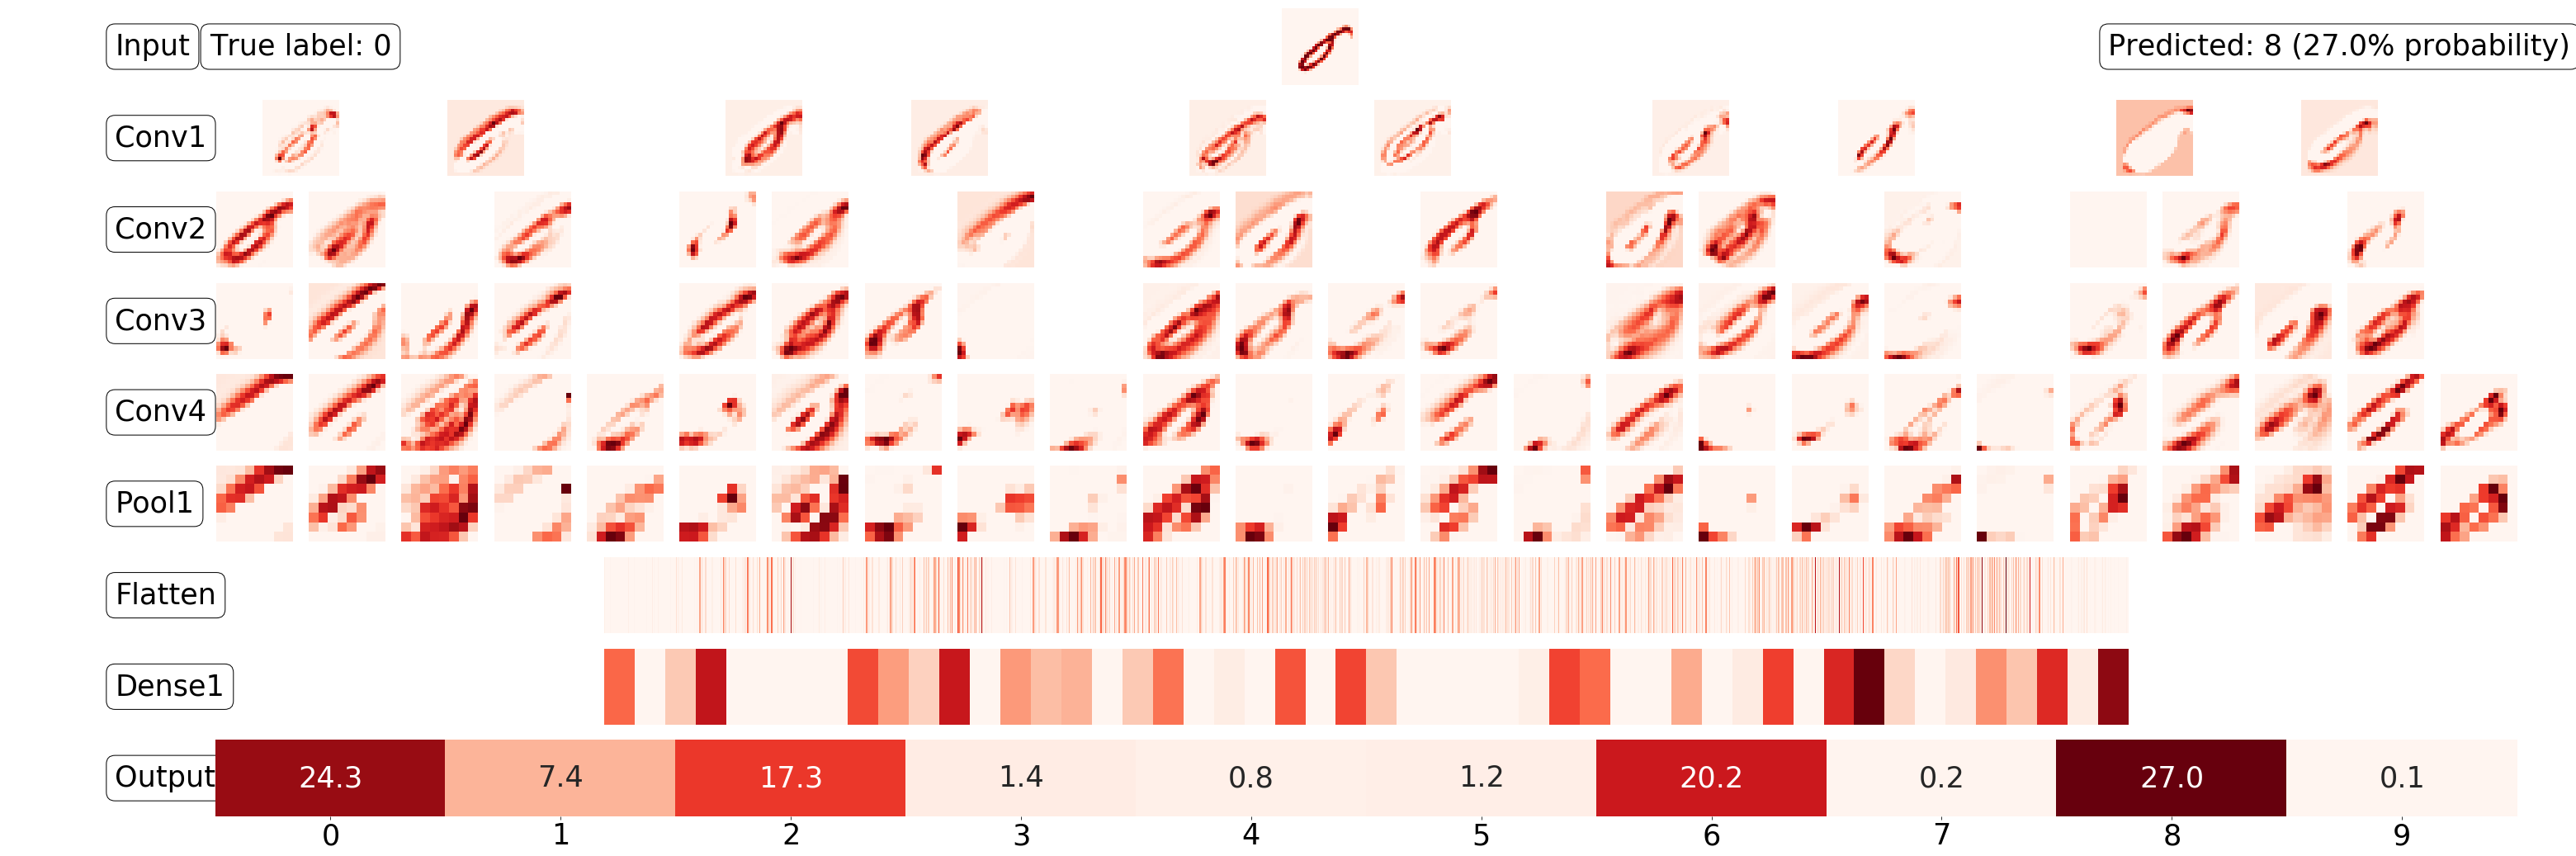

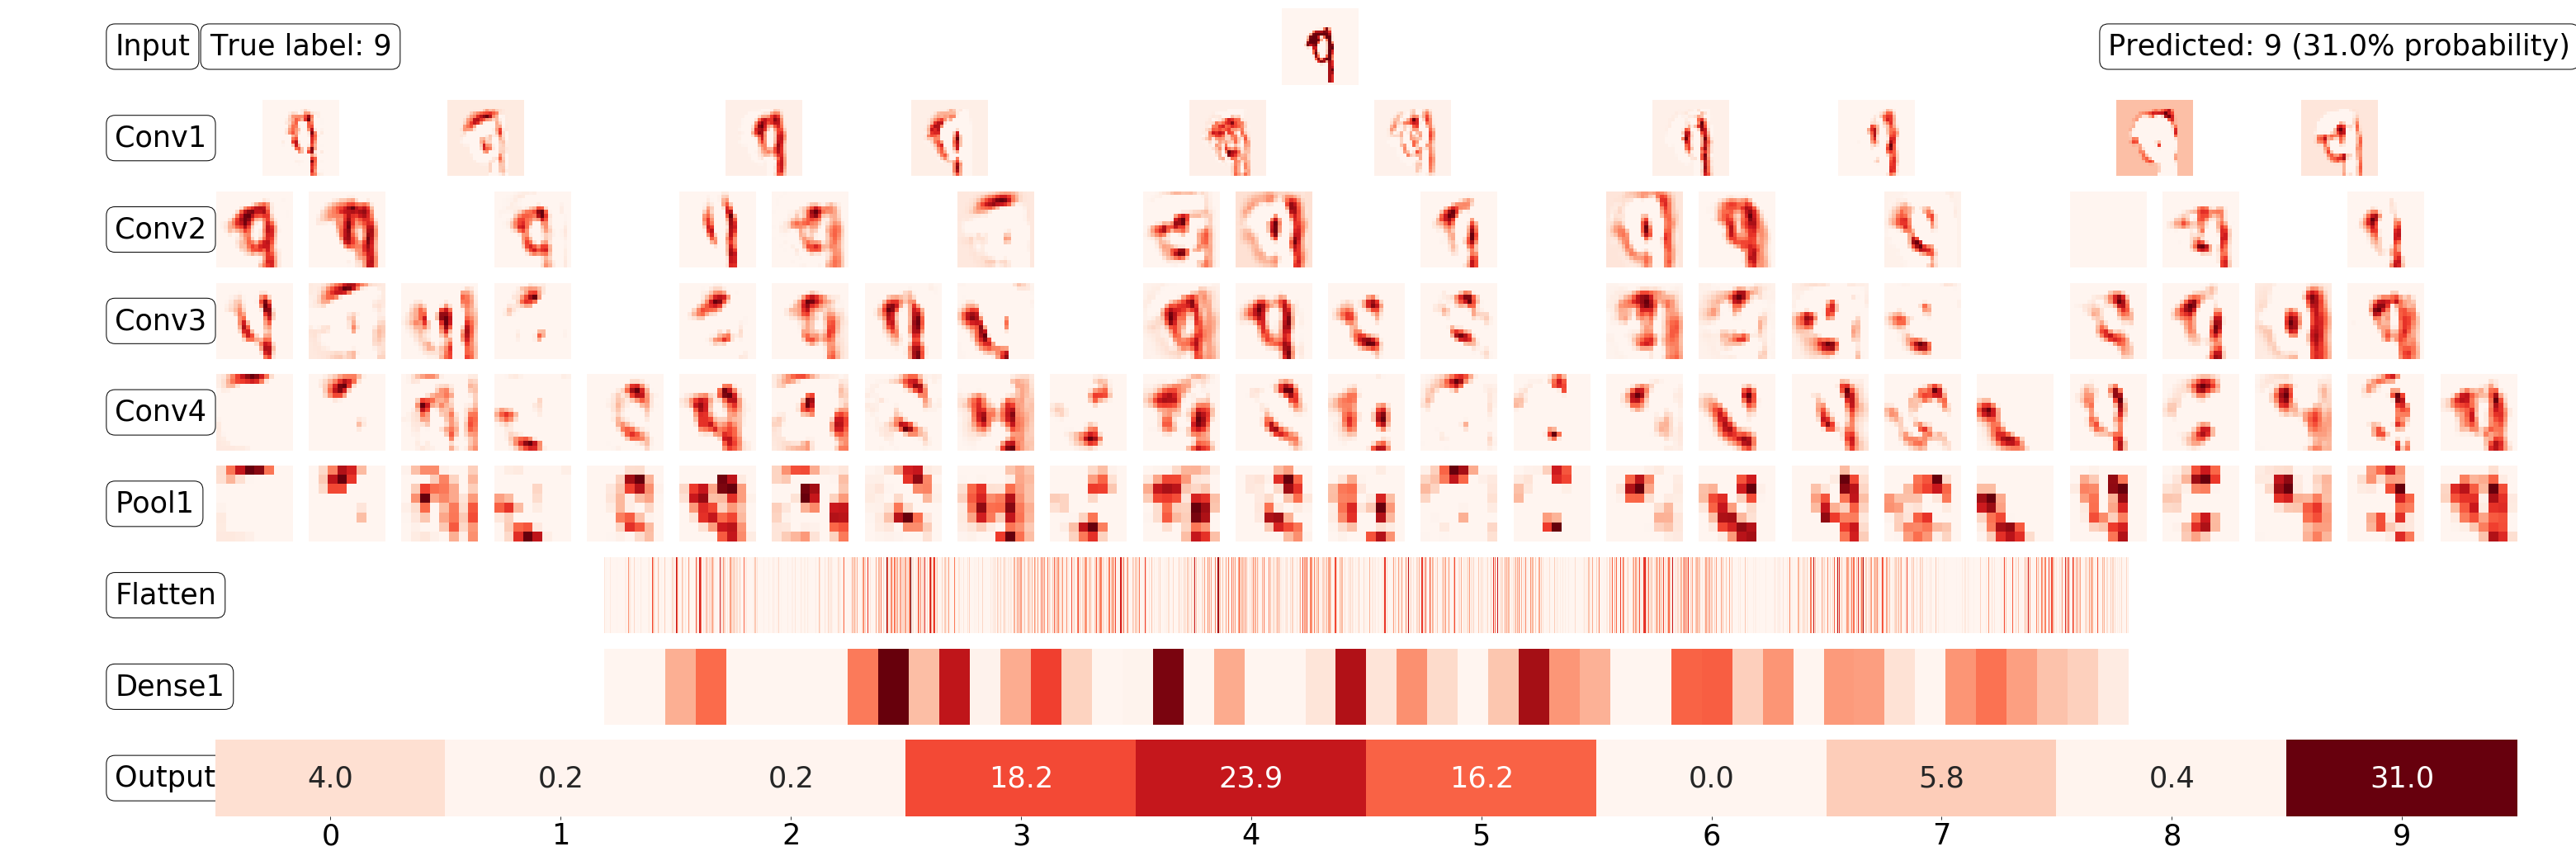

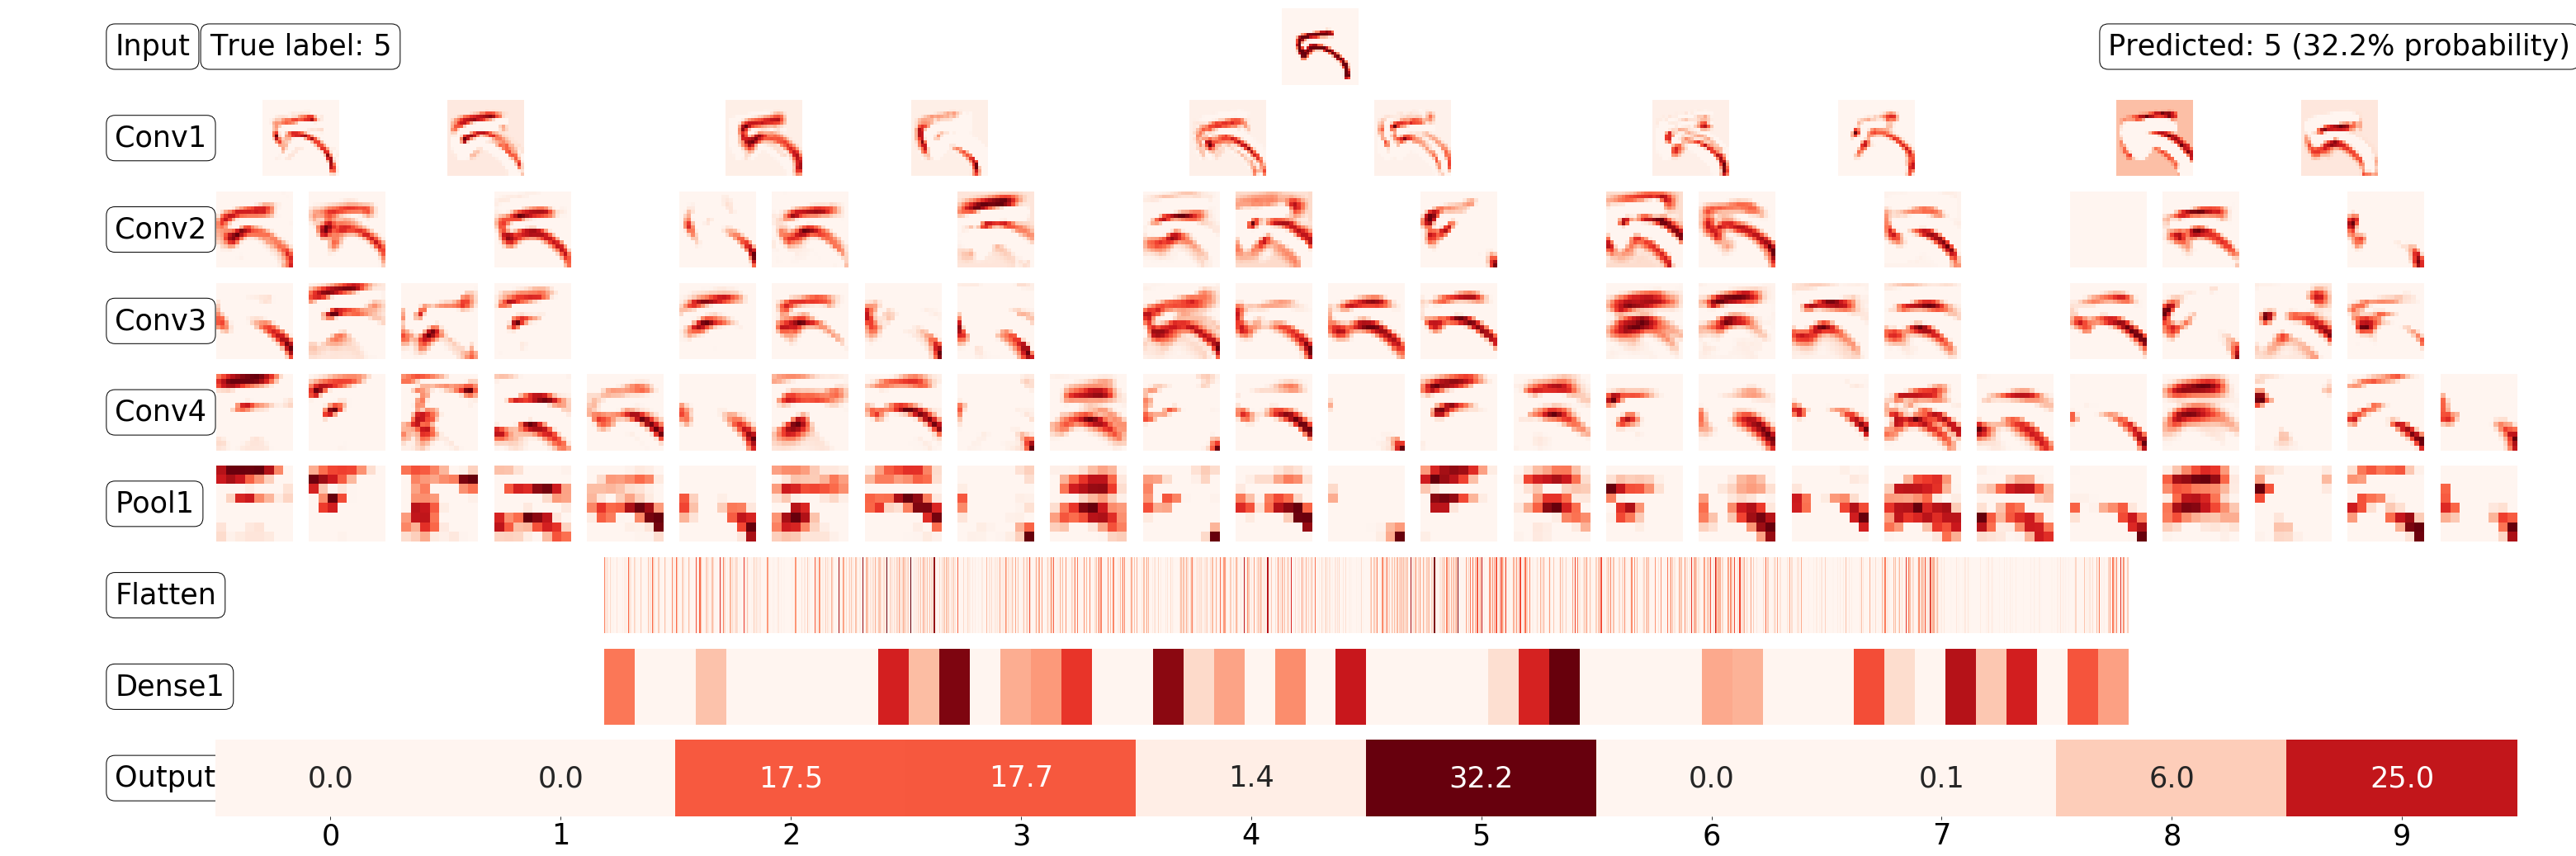

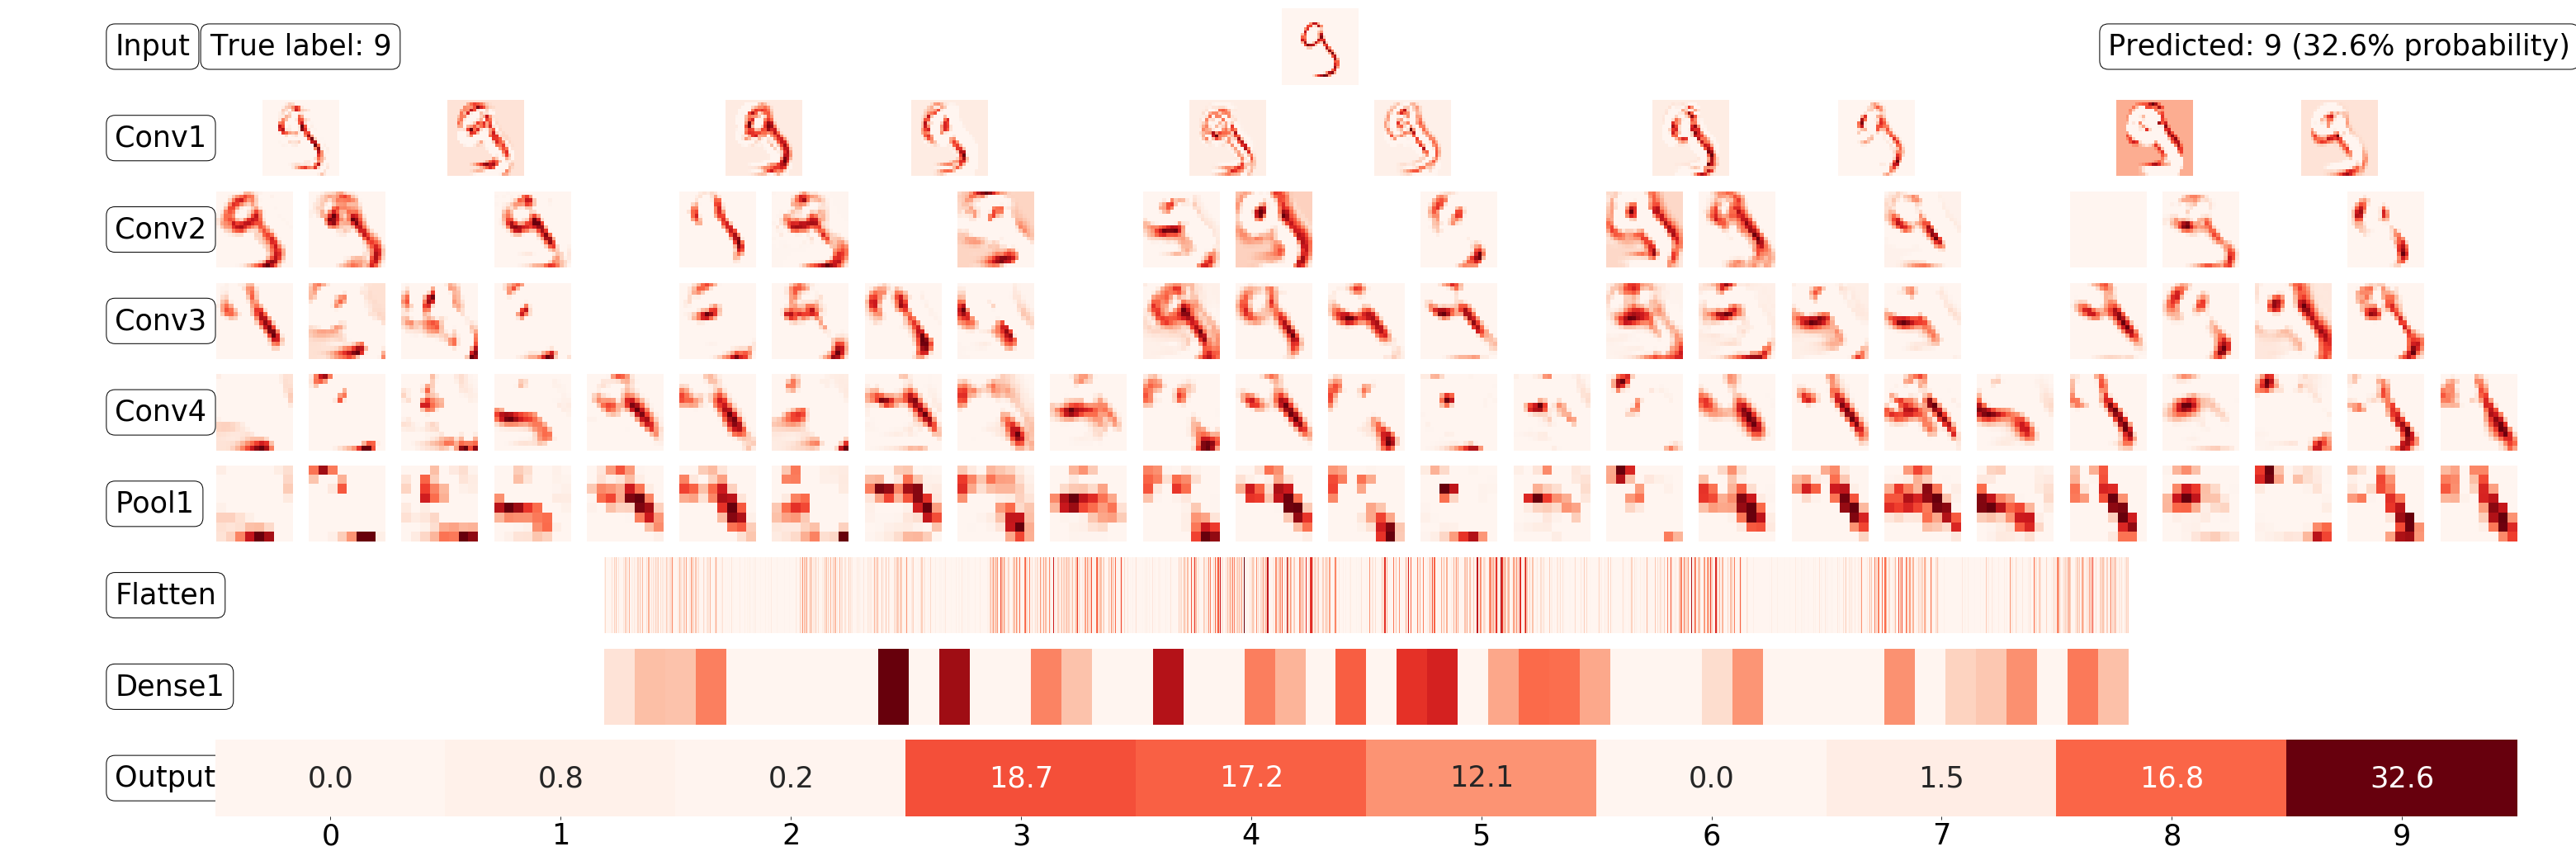

In [8]:
nvis.visualise_unsure()

Loading data...
Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 2s 66us/step - loss: 0.7892 - acc: 0.8069 - val_loss: 0.4514 - val_acc: 0.8863
Epoch 2/3
33600/33600 [==============================] - 2s 56us/step - loss: 0.4020 - acc: 0.8928 - val_loss: 0.3603 - val_acc: 0.9057
Epoch 3/3
33600/33600 [==============================] - 2s 55us/step - loss: 0.3440 - acc: 0.9064 - val_loss: 0.3267 - val_acc: 0.9130
Calculating output at each layer...
Flatten layer has shape (42000, 784)
Output layer has shape (42000, 10)


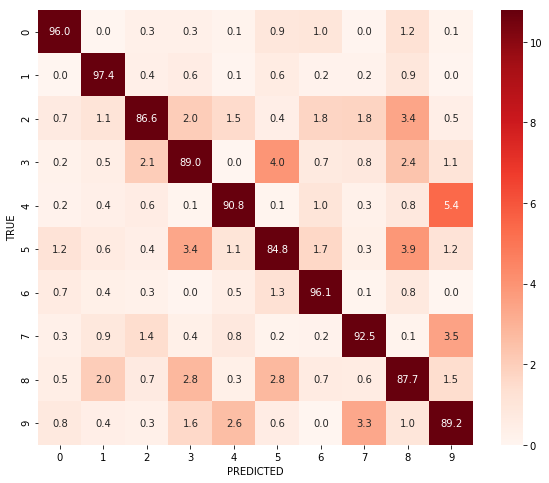

In [10]:
layers = [
          Flatten(name='Flatten'),
          ######################################################
          # BE CAREFUL IF CHANGING OUTPUT LAYER
          Dense(num_classes, activation='softmax',
                          name='Output')
          ######################################################
        ]

nvis = NetworkVisualiser(layers, data_file=data_file, label_col=label_col, 
                         num_classes=num_classes, img_rows=img_rows, img_cols=img_cols)

nvis.fit(epochs=3)
nvis.show_conf_matrix()

Calculating TSNE representations...
Input...Flatten...Output...Done!


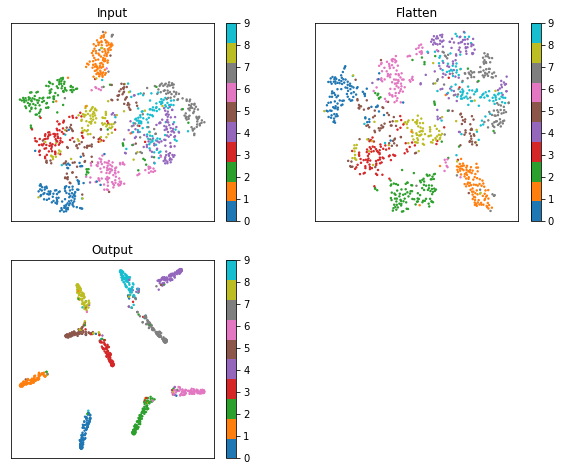

In [11]:
nvis.tsne_layers(range(1000))

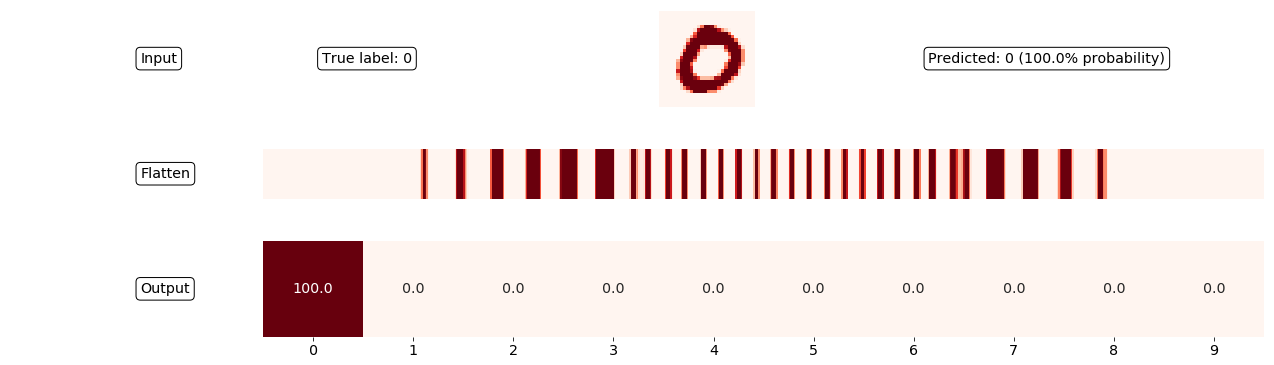

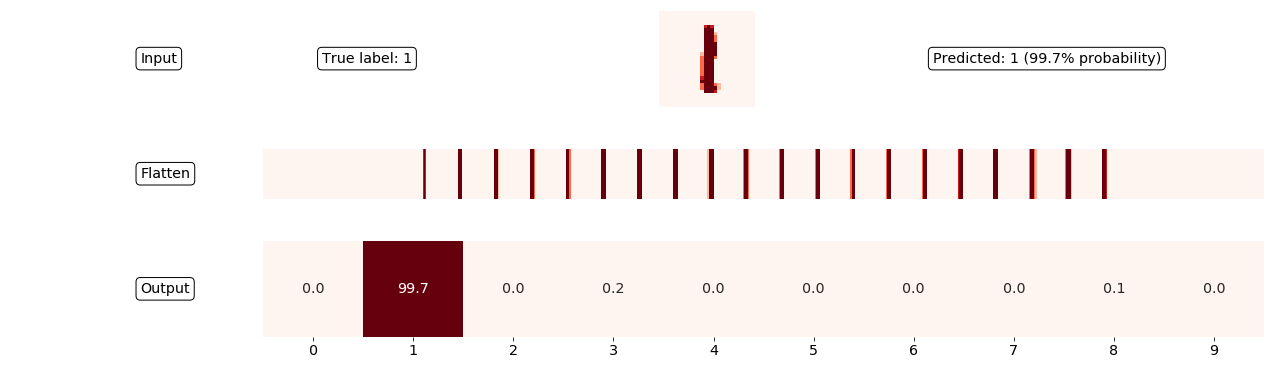

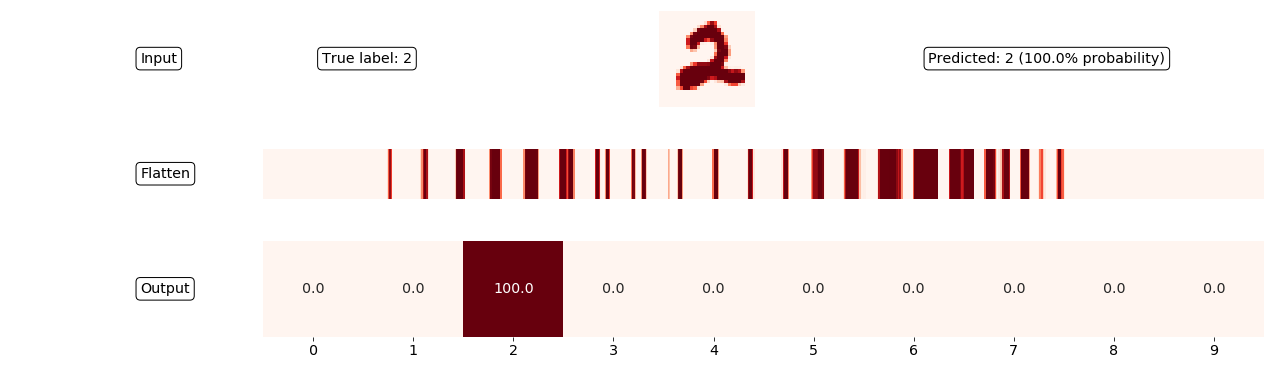

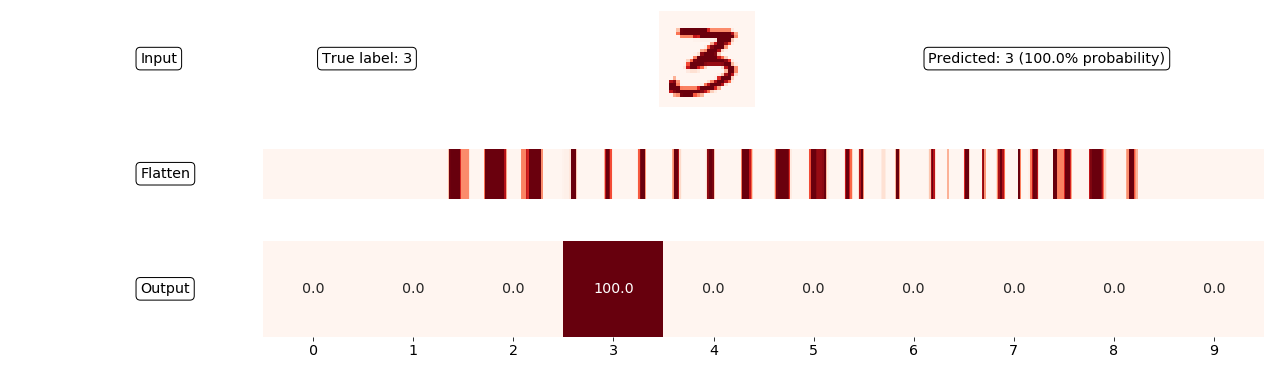

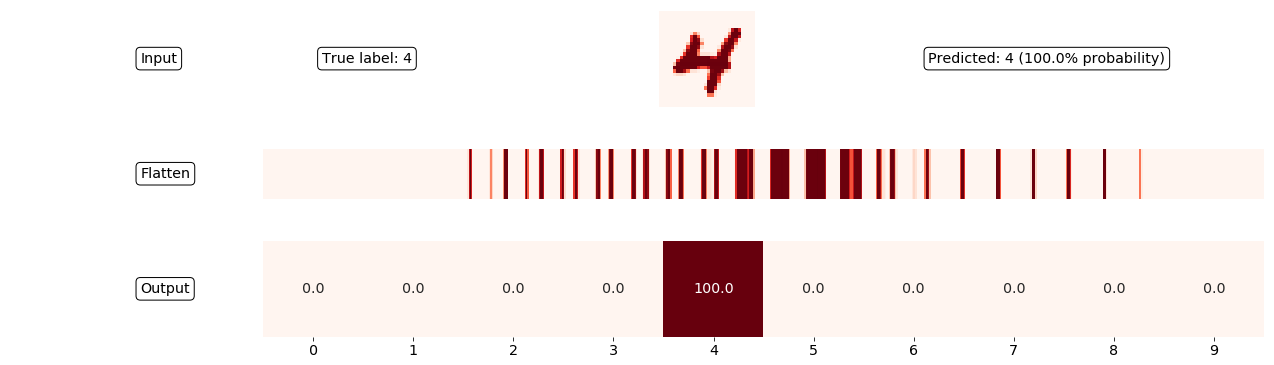

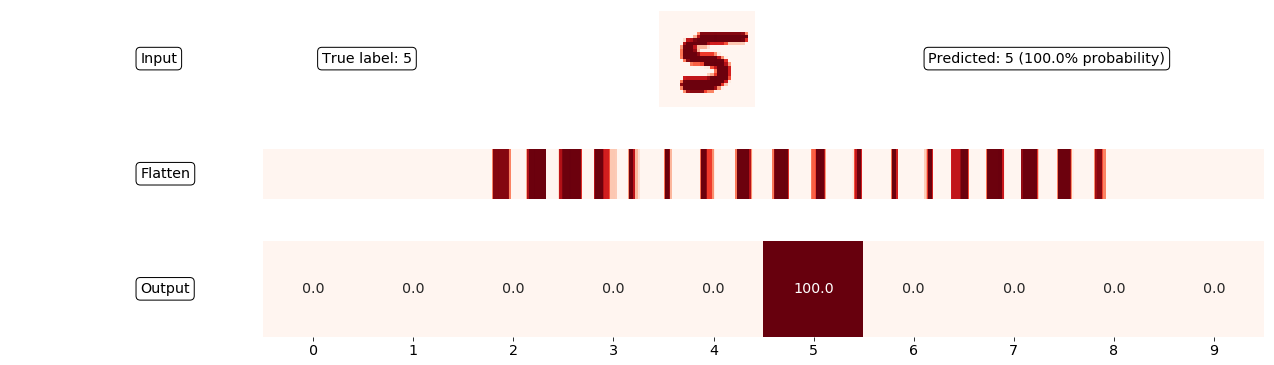

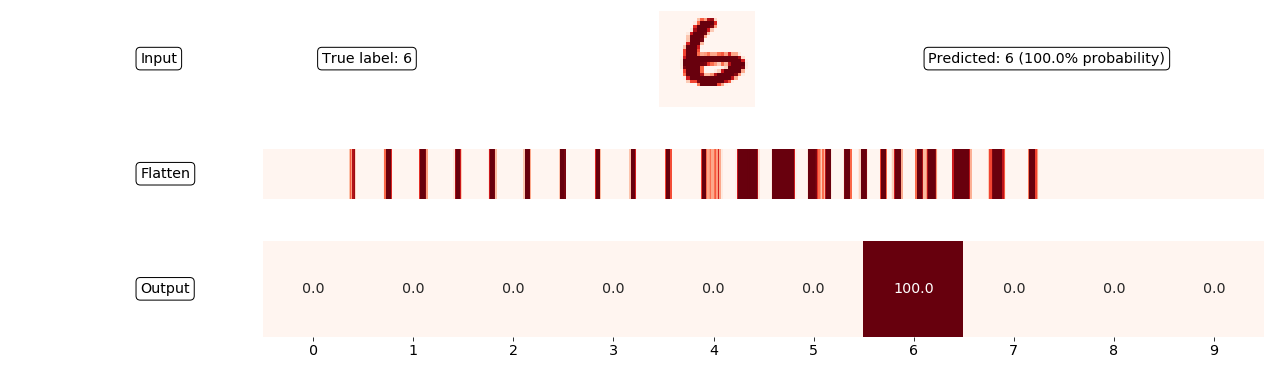

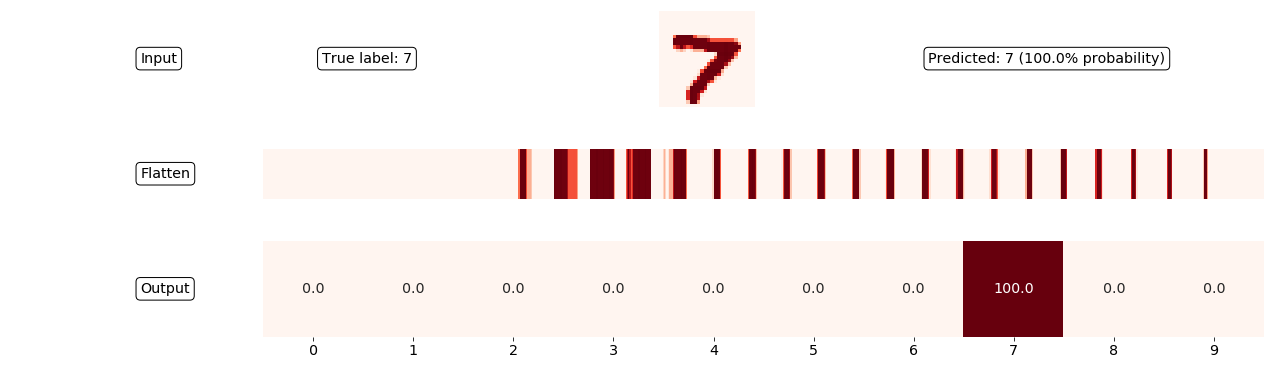

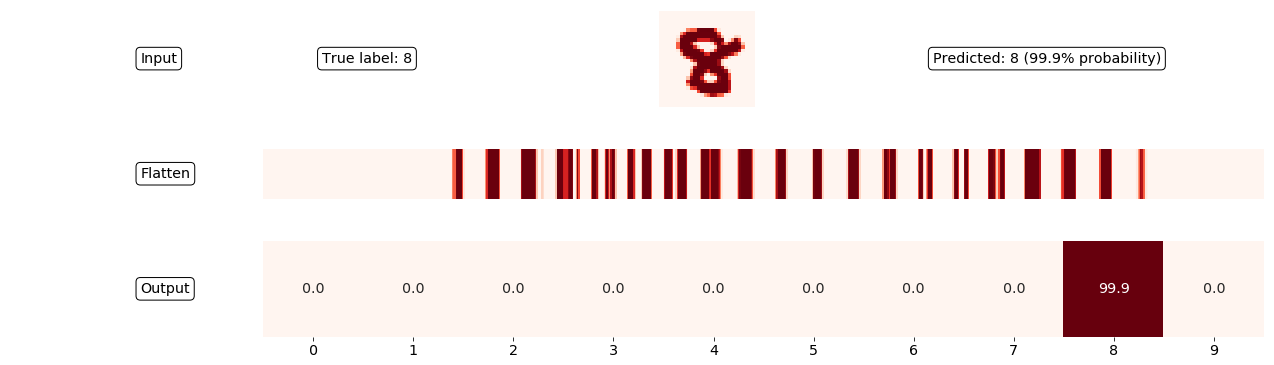

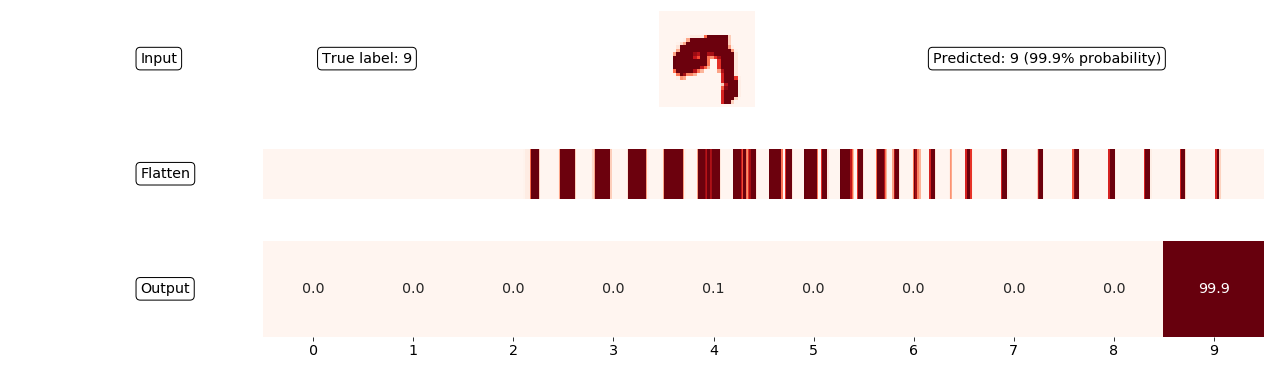

In [12]:
nvis.visualise_classbest()

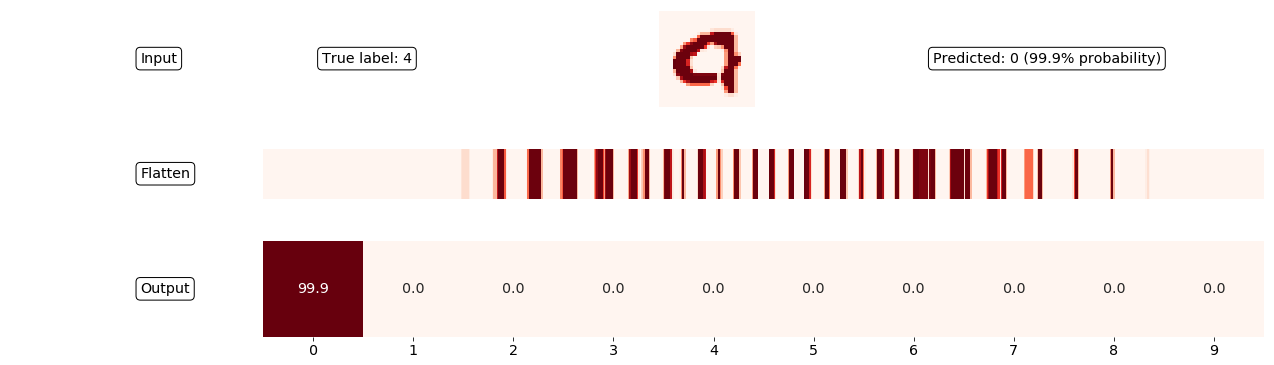

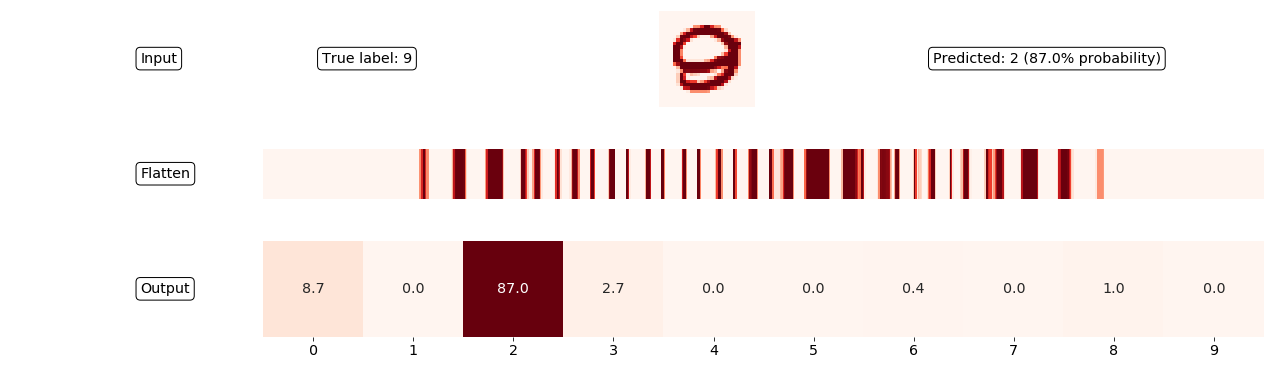

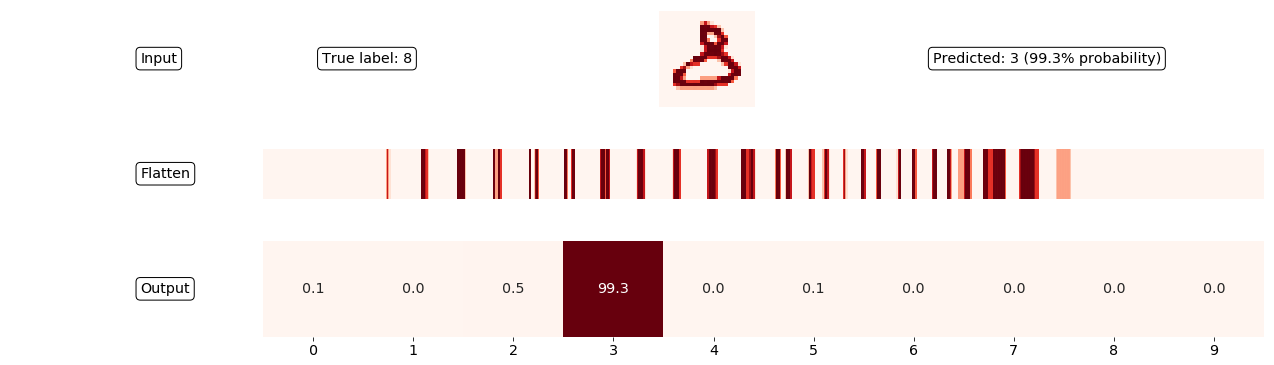

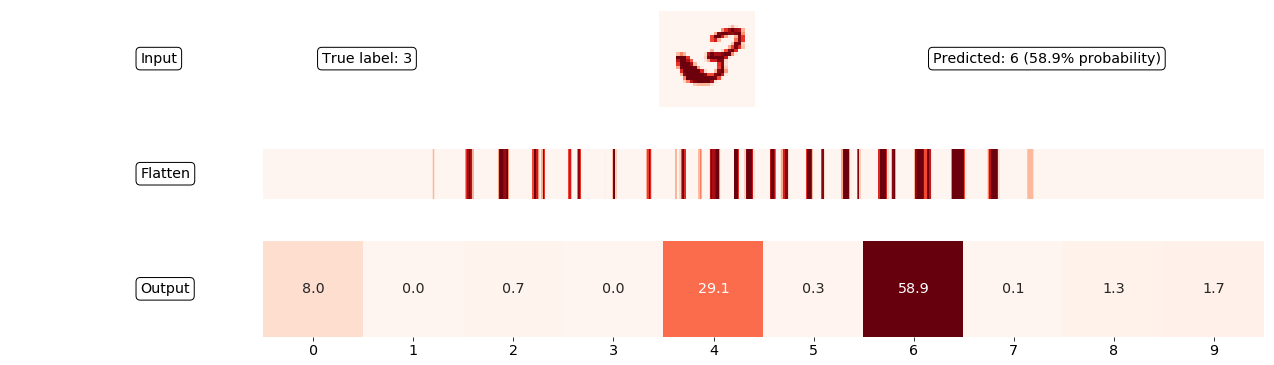

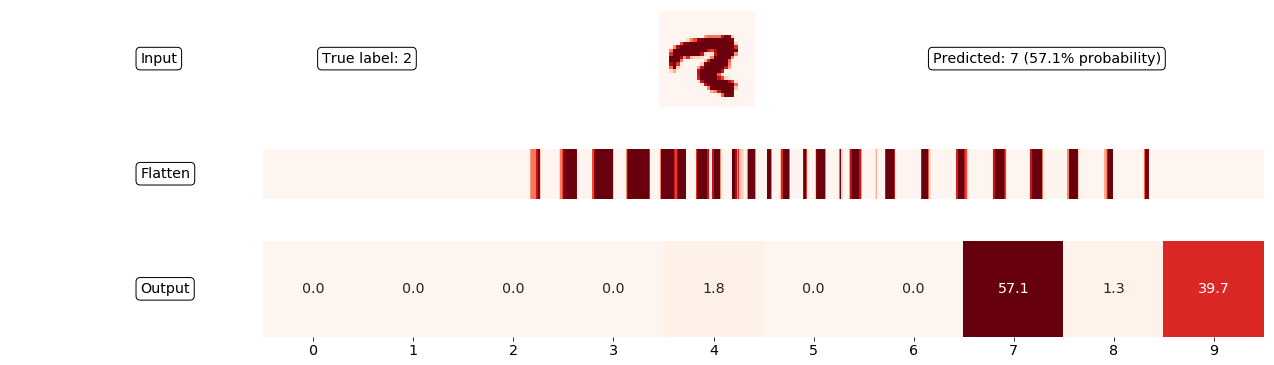

In [13]:
nvis.visualise_worst()

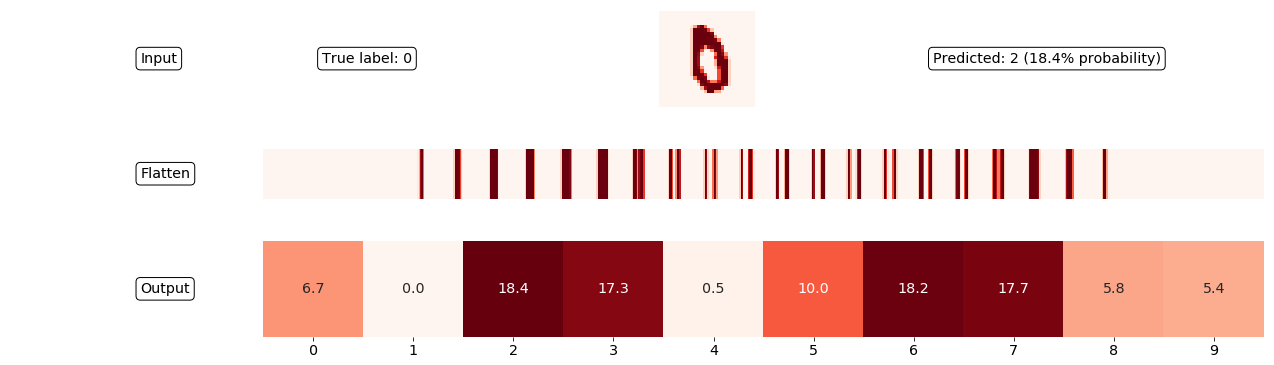

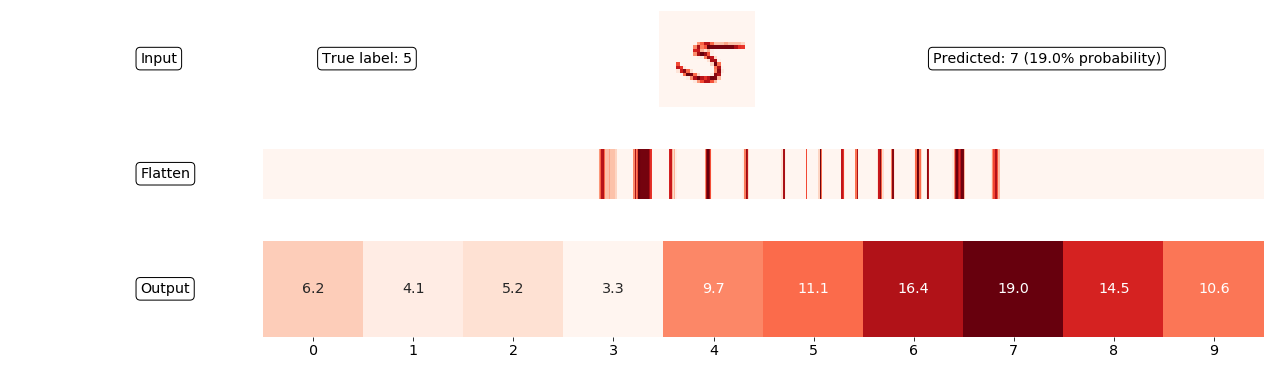

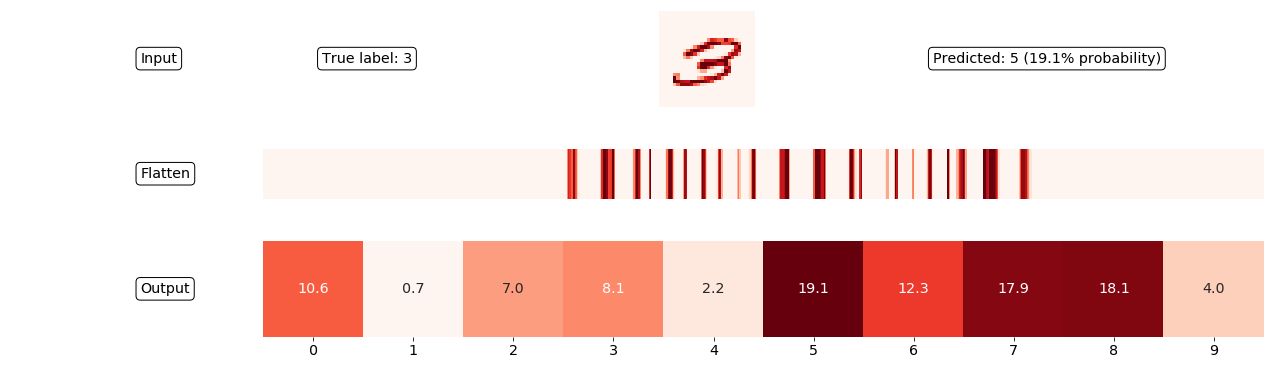

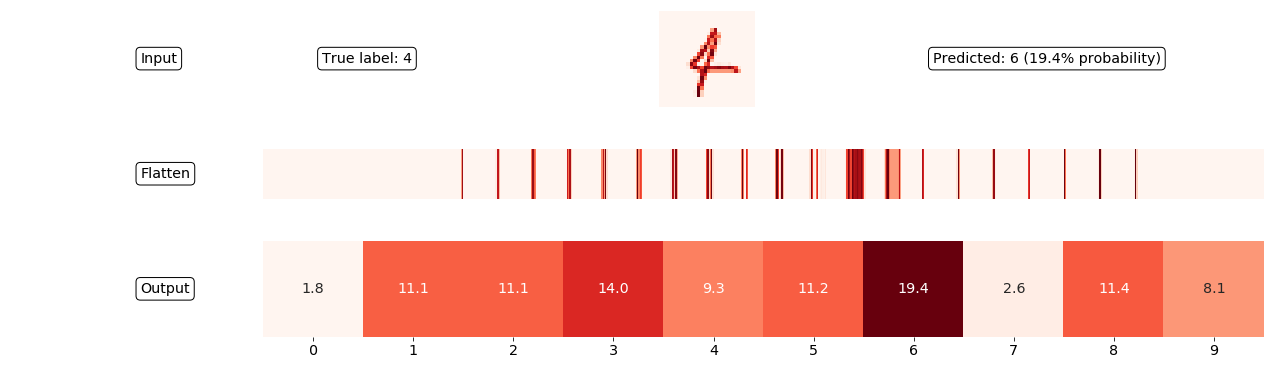

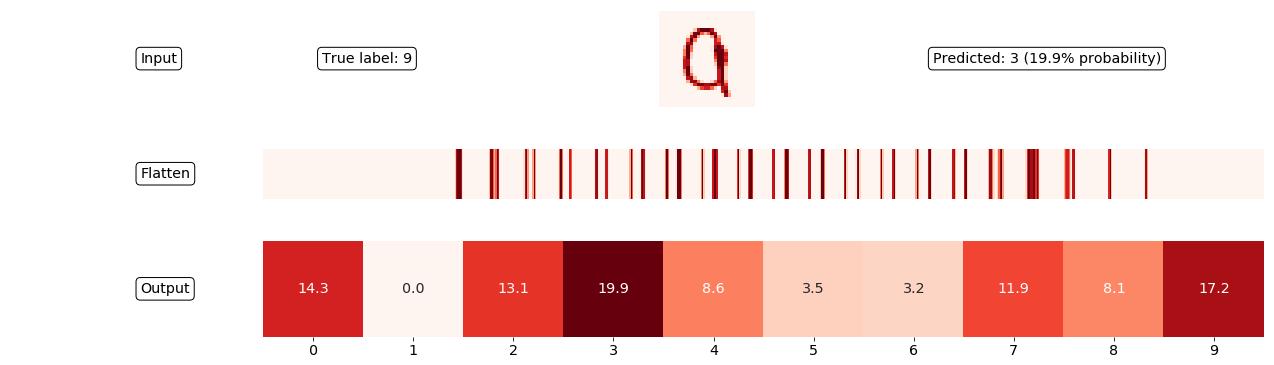

In [14]:
nvis.visualise_unsure()